# CDE-1 tailing analysis

## General description

### Adaptor trimming

The Illumina TruSeq smallRNA 3' adaptor (TGGAATTCTCGGGTGCCAAGG) was removed with cutadapt v1.9. 

Command line:

    cutadapt --discard-untrimmed --minimum-length 20 -a TGGAATTCTCGGGTGCCAAGG -o <outfname> <infname>

### Read alignment

Adaptor-trimmed reads were aligned to the Ensembl WBcel235 genome using STAR v2.5.1b with the following criteria:

- Multi-mapping alignments are discarded
- Exon-exon junction mapping reads are discarded
- Gaps or insertions are not allowed
- Untemplated (soft-clipped) residues are allowed on both ends

Command line:

    STAR --alignEndsType Local --outSAMtype BAM SortedByCoordinate --runThreadN 6 --outFilterMultimapNmax 1 --alignIntronMax 1 --readFilesCommand gunzip -c --scoreInsOpen -10000 --scoreDelOpen -10000 --outFilterMismatchNmax 0 --genomeDir <genome_index_path> --readFilesIn <infnames> --outFileNamePrefix <outfprefix>

The result of these parameters is that the only allowed cigars will be of the form [1..N]M [0..R]S or [0..R]S[1..N]M: a certain number of consecutive matching nucleotides in the center, with optional untemplated flanking nucleotides (on one side or the either depending on whether the read is fw or rv).

Dicer product are defined as two reads *of the same length* in opposite strands, with a 3' overhang of 2nt.

In [2]:
# ipcontroller --ip=*
# ipcluster engines -n 8

import ipyparallel as ipp
rc = ipp.Client('ipcontroller-client.json',sshserver="farm4")
dview = rc[:]
lview = rc.load_balanced_view()

In [3]:
%%px --local
#local + remote env init

import pandas as pd
import pysam
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "Myriad Pro"
import numpy as np
import subprocess, shlex
from tstk.common import *
from tstk.get_overlapping_reads import getdicerproducts
from tstk.io import openfastx, parsefastx
import json
import glob
%matplotlib inline

ROOTRMT="/ROOTDIR/"
SHRDRMT="/SHRDRMT/"
BINRMT="/BINDIR/"

chrnames_v = ["RNA1","RNA2"]
chrnames_w = ["I","II","III","IV","V","X"]

In [4]:
@lview.remote(block=False)
def runcmd(cmd,outfname=None):
    import subprocess

    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,shell=True)
    output = process.communicate()[0].decode()
    if outfname:
        with open(outfname,"w") as of:
            of.write(output)
        return("Wrote output to {}".format(outfname))
    else:
        if output:
            return output.split("\n")
        else:
            return "runcmd(): command generated no output"
        
@lview.remote(block=True)
def rglob(d):
    return [f for f in glob.glob(d)]

In [5]:
%%px

#set up some remote helper functions
def tailcigar(r):
    M = 0
    S = 4
    if len(r.cigar) == 2:
        if r.is_reverse:
            return r.cigar[0][0] == S and r.cigar[1][0] == M
        else:
            return r.cigar[0][0] == M and r.cigar[1][0] == S
    else:
        return False
    
def goodcigar(r):
    M = 0
    S = 4
    if len(r.cigar) == 2:
        if r.is_reverse:
            return r.cigar[0][0] == S and r.cigar[1][0] == M
        else:
            return r.cigar[0][0] == M and r.cigar[1][0] == S
    elif len(r.cigar) == 1:
        return r.cigar[0][0] == M
    else:
        return False

def good5nt(r,nt):
    if r.is_reverse:
        return r.seq[-1] == compnt[nt]
    else:
        return r.seq[0] == nt
    
def filter_boyer(filter_seq,target_seqs,target_seqs_flat,target_seqs_flat_divs,only3p):
    '''
    Returns all target_seqs that contain filter_seq.
    '''
    import bisect

    matched_target_seqs = []
    matched_target_ids = []
    i = target_seqs_flat.find(filter_seq)
    while i != -1: 
        p = bisect.bisect_right(target_seqs_flat_divs, i) - 1 
        matched_target_seq = target_seqs[p]
        if not only3p or matched_target_seq[1].find(filter_seq) == 0:
            matched_target_seqs.append(matched_target_seq)
        i = target_seqs_flat.find(filter_seq, target_seqs_flat_divs[p] + len(matched_target_seq[1]))

    return matched_target_seqs

def filterseqs(target_seqs,filter_seqs,only3p=False):
    '''
    Returns all target_seqs that contain at least one of filter_seqs,
    and all filter_seqs that are contained in at least one of target_seqs.
    '''
    import re

    matched_target_seqs = []
    matched_target_ids=[]
    matching_filter_seqs = []

    target_seqs_flat = "#"+"#".join([s[1] for s in target_seqs]) 
    target_seqs_flat_divs = [m.start()+1 for m in re.finditer('#', target_seqs_flat)]

    for i,fs in enumerate(filter_seqs):
        if fs.is_reverse:
            filter_seq = revcomp(fs.query_alignment_sequence)
        else:
            filter_seq = fs.query_alignment_sequence
            
        m = filter_boyer(filter_seq,target_seqs,target_seqs_flat,target_seqs_flat_divs,only3p) 
        matched_target_seqs += m
        if len(m) > 0:
            matching_filter_seqs.append(fs)

    return(set(matched_target_seqs),matching_filter_seqs)

def get_tails(alignment,lengths,nt5p,stranded):
    if stranded:
        tails = {"-":[],"+":[]}
        nreads = {"-":0,"+":0}
    else:
        tails = []
        nreads = 0
    for r in alignment:
        if (not lengths or r.alen in lengths) and (not nt5p or good5nt(r,nt5p)) and goodcigar(r):
            if r.is_reverse:
                if stranded:
                    nreads["-"] += 1
                else:
                    nreads += 1
                if tailcigar(r):
                    seq = revcomp(r.seq)
                    tail = seq[-r.cigar[0][1]:]
                    if stranded:
                        tails["-"].append(tail)
                    else:
                        tails.append(tail)
            else:
                if stranded:
                    nreads["+"] += 1
                else:
                    nreads += 1
                if tailcigar(r):
                    seq = r.seq
                    tail = seq[-r.cigar[1][1]:]
                    if stranded:
                        tails["+"].append(tail)
                    else:
                        tails.append(tail)
    return (tails,nreads)

In [6]:
#functions to run remotely in parallel

@dview.parallel(block=False)
def get_libsize(args):
    sid = args["sid"]
    rep = args["rep"]
    fname=args["fname"]
    return (sid,rep,sum(int(r[0].split("-")[1]) for r in parsefastx(openfastx(fname)[3])))

@dview.parallel(block=False)
def get_tails_srna(params):
    sid=params["sid"]
    rep=params["rep"]
    fpath=params["fname"]
    chrname=params["chrname"]
    lengths=params["lengths"]
    nt5p=params["nt5p"]
    
    bam = pysam.AlignmentFile(fpath)
    tails,nreads = get_tails(bam.fetch(chrname),lengths,nt5p,True)

    return {"sid":sid,"rep":rep,"chrname":chrname,"tails":tails,"nreads":nreads}

@dview.parallel(block=False)
def get_tails_sirna(params):
    sid=params["sid"]
    rep=params["rep"]
    fpath=params["fname"]
    chrname=params["chrname"]
    lengths=params["lengths"]
    nt5p=params["nt5p"]
    annfile=params["annfile"]
    
    bam = pysam.AlignmentFile(fpath)
    nreads = 0
    tails = []
    ids = []
    with open(annfile) as f:
        for r in f:
            row = r.split()
            gene_chrname = row[0]
            if gene_chrname == chrname and "protein_coding" in r and "ensembl\tgene" in r:
                gene_start = int(row[3])
                gene_end = int(row[4])
                gene_strand = row[6]

                for aln in bam.fetch(reference=gene_chrname,start=gene_start,end=gene_end):
                    if aln.alen in lengths and goodcigar(aln) and good5nt(aln,nt5p):
                        if aln.is_reverse:
                            if gene_strand == "+":
                                ids.append(aln.query_name)
                                nreads +=1
                                if tailcigar(aln):
                                    seq = revcomp(aln.seq)
                                    tails.append(seq[-aln.cigar[0][1]:])
                                    
                        else:
                            if gene_strand == "-":
                                nreads +=1
                                ids.append(aln.query_name)
                                if tailcigar(aln):
                                    seq = aln.seq
                                    if len(aln.cigar) == 2:
                                        tails.append(seq[-aln.cigar[1][1]:])
    return {"sid":sid,"rep":rep,"chrname":chrname,"tails":tails,"nreads":nreads,"ids":ids}
                            
@dview.parallel(block=False)
def get_tails_dp(params):
    sample=params["sid"]
    rep=params["rep"]
    fpath=params["fname"]
    chrname=params["chrname"]
    lengths=params["lengths"]
    offset=params["offset"]
    
    res = getdicerproducts(fpath,chrname,lengths,offset)
    
    tails,nreads = get_tails(res,lengths,None,True)
    
    #tails = {"-":[],"+":[]}
    #nreads = {"-":0,"+":0}
    #for read in res:
    #    if goodcigar(res):
    #        if read.is_reverse:
    #            nreads["-"] += 1
    #            if tailcigar(read):
    #                seq = revcomp(read.seq)
    #                tails["-"].append(seq[-read.cigar[0][1]:])
    #        else:
    #            nreads["+"] += 1
    #            if tailcigar(read):
    #                seq = read.seq
    #                tails["+"].append(seq[-read.cigar[1][1]:])

    return {"sid":sample,"rep":rep,"chrname":chrname,"tails":tails,"nreads":nreads}

@dview.parallel(block=False)
def get_tails_list(params):
    sid=params["sid"]
    rep=params["rep"]
    fpath_targets=params["fname_targets"]
    fpath_filters=params["fname_filters"]
    chrname=params["chrname"]
    
    targets = [(s[0],s[1]) for s in parsefastx(open(fpath_targets))]
    
    bam = pysam.AlignmentFile(fpath_filters)
    #bam = pysam.AlignmentFile("/home/tdido/tmp/jeremie/" + fname_filters)
    
    matched_target_seqs, matching_filter_seqs = filterseqs(targets,bam.fetch(chrname))
    
    tails,nreads = get_tails(matching_filter_seqs,None,None,False)
    #tails = []
    #nreads = 0
    #for r in matching_filter_seqs:
    #    if goodcigar(r):
    #        nreads += 1
    #        if r.is_reverse:
    #            if tailcigar(r):
    #                seq = revcomp(r.seq)
    #                tails.append(seq[-r.cigar[0][1]:])
    #        else:
    #            if tailcigar(r):
    #                seq = r.seq
    #                if len(r.cigar) == 2: 
    #                    tails.append(seq[-r.cigar[1][1]:])
    return {"sid":sid,"rep":rep,"chrname":chrname,"tails":tails,"nreads":nreads}

In [7]:
# local functions

#reshape the results into a dictionary, grouping by cat/sid
def reshape_remote(data):#,unstranded=False):
    '''
    Group the remote results from parallel functions for downstream analysis.
    '''
    for cat in data:
        if not data[cat]["async"]["done"] and data[cat]["async"]["res"] and data[cat]["async"]["res"].ready():
            data[cat]["data"]["chrdata"] = data[cat]["async"]["res"].get()
            for chrdata in data[cat]["data"]["chrdata"]:
                try:
                    for strand in chrdata["nreads"]:
                        if chrdata["sid"] not in data[cat]["data"]:
                            data[cat]["data"][chrdata["sid"]] = {chrdata["rep"]:{"nreads":{"+":0,"-":0},"tails":{"+":[],"-":[]}}}
                        if chrdata["rep"] not in data[cat]["data"][chrdata["sid"]]:
                            data[cat]["data"][chrdata["sid"]][chrdata["rep"]] = {"nreads":{"+":0,"-":0},"tails":{"+":[],"-":[]}}
                        data[cat]["data"][chrdata["sid"]][chrdata["rep"]]["nreads"][strand] += chrdata["nreads"][strand]
                        data[cat]["data"][chrdata["sid"]][chrdata["rep"]]["tails"][strand] += chrdata["tails"][strand]
                except TypeError:
                    if chrdata["sid"] not in data[cat]["data"]:
                        data[cat]["data"][chrdata["sid"]] = {chrdata["rep"]:{"nreads":0,"tails":[]}}
                    if chrdata["rep"] not in data[cat]["data"][chrdata["sid"]]:
                        data[cat]["data"][chrdata["sid"]][chrdata["rep"]] = {"nreads":0,"tails":[]}
                    data[cat]["data"][chrdata["sid"]][chrdata["rep"]]["nreads"] += chrdata["nreads"]
                    data[cat]["data"][chrdata["sid"]][chrdata["rep"]]["tails"] += chrdata["tails"]
            data[cat]["data"].pop("chrdata")
            data[cat]["async"]["done"] = True
    return data

def plot_tails(tails,normfactor,title,ofname,ylim=1,legend=True,npos=4,save=True):
    pos = {i:{"A":0,"C":0,"U":0,"G":0} for i in range(1,npos+1)}
    
    for tail in tails:
        tail = tail.replace("T","U")
        for i,n in enumerate(tail):
            i+=1
            if i > npos:
                break
            if n != "N":
                pos[i][n] += 1

    for p in pos:
        for n in pos[p]:
            try:
                pos[p][n] /= normfactor
            except ZeroDivisionError:
                pass
            
    df = pd.DataFrame(pos).transpose()
    ax = df[0:5].plot(kind='bar',stacked=True,rot=0,legend=legend,color=["#a8786e","#67bf5c","#729ece","#ed665d"])
    ax.set_ylim(0,ylim)
    ax.set_title("{}".format(title))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', direction='out')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if save :
        fig = ax.get_figure()
        fig.savefig('out/{}.svg'.format(ofname))
    
#def plot_results(data,cats=None,prefix="",ylim=1):
#    if not cats:
#        cats = data.keys()
#    else:
#        if type(cats) == str:
#            cats = [cats]
#            
#    for cat in cats:
#        try:
#            for sid in data[cat]["data"]:
#                for rep in data[cat]["data"][sid]:
#                    title = "{} / {}.{} ({} seqs)".format(cat,sid,rep,data[cat]["data"][sid][rep]["nreads"])
#                    ofname = '{}{}_{}.{}'.format(prefix,cat,sid,rep)
#                    plot_tails(data[cat]["data"][sid][rep]["tails"],data[cat]["data"][sid][rep]["nreads"],title,ofname,ylim=ylim)
#        except TypeError:
#            for sid in data[cat]["data"]:
#                for rep in data[cat]["data"][sid]:
#                    for strand in data[cat]["data"][sid][rep]["tails"]:
#                        title = "{} / {}.{}{} ({} seqs)".format(cat,sid,rep,strand,data[cat]["data"][sid][rep]["nreads"][strand])
#                        ofname = '{}{}_{}.{}_{}'.format(prefix,cat,sid,rep,strand)
#                        plot_tails(data[cat]["data"][sid][rep]["tails"][strand],data[cat]["data"][sid][rep]["nreads"][strand],title,ofname,ylim=ylim)
                        
def plot_results(data,cats=None,prefix="",ylim=1,destrand=False,legend=False,npos=4,save=True):
    if not cats:
        cats = data.keys()
    else:
        if type(cats) == str:
            cats = [cats]
            
    for cat in cats:
        for sid in sorted(data[cat]["data"]):
            for rep in data[cat]["data"][sid]:
                if type(data[cat]["data"][sid][rep]["nreads"]) == int or "+" not in data[cat]["data"][sid][rep]["nreads"].keys() or destrand:
                    if destrand:
                        nreads = data[cat]["data"][sid][rep]["nreads"]["+"] + data[cat]["data"][sid][rep]["nreads"]["-"]
                        tails = data[cat]["data"][sid][rep]["tails"]["+"] + data[cat]["data"][sid][rep]["tails"]["-"]
                    else:
                        nreads = data[cat]["data"][sid][rep]["nreads"]
                        tails = data[cat]["data"][sid][rep]["tails"]
                    
                    title = "{} / {}.{} ({} seqs)".format(cat,sid,rep,nreads)
                    ofname = '{}{}_{}.{}'.format(prefix,cat,sid,rep)
                    plot_tails(tails,nreads,title,ofname,ylim=ylim,legend=legend,npos=npos,save=save)
                else:
                    for strand in data[cat]["data"][sid][rep]["tails"]:
                        title = "{} / {}.{}{} ({} seqs)".format(cat,sid,rep,strand,data[cat]["data"][sid][rep]["nreads"][strand])
                        ofname = '{}{}_{}.{}_{}'.format(prefix,cat,sid,rep,strand)
                        plot_tails(data[cat]["data"][sid][rep]["tails"][strand],data[cat]["data"][sid][rep]["nreads"][strand],title,ofname,ylim=ylim,legend=legend,npos=npos,save=save)

# Tailing

## Small RNAs

Libsizes

In [9]:
sids = [
    "cde-1_mj414-nphos",
    "cde-1_mj414-phos",
    "cde-1_tm1021-drh-1_ok3495-nphos",
    "cde-1_tm1021-drh-1_ok3495-phos",
    "cde-1_tm1021-nphos",
    "cde-1_tm1021-phos",
    "cde-1_tm1021-rde-1_ne219-nphos",
    "cde-1_tm1021-rde-1_ne219-phos",
    "drh-1_ok3495-nphos",
    "drh-1_ok3495-phos",
    "rde-1_ne219-nphos",
    "rde-1_ne219-phos",
    "WT-nphos",
    "WT-phos"
]
replicates = ["1","2"]

libsize_async = get_libsize.map([{"sid":sid,"rep":rep,"fname":"{}/out/exp2_{}.{}_collapse_collapse_raw.fasta.gz".format(ROOTRMT,sid,rep)} for rep in replicates for sid in sids])

In [10]:
libsizes = {sid:{rep:None for rep in replicates} for sid in sids}

for result in libsize_async.get():
    libsizes[result[0]][result[1]] = result[2]

### Worm RNAs
Small RNAs mapping to the worm genome


In [7]:
#:dontrun

sids = [
    "cde-1_mj414-nphos",
    "cde-1_mj414-phos",
    "cde-1_tm1021-drh-1_ok3495-nphos",
    "cde-1_tm1021-drh-1_ok3495-phos",
    "cde-1_tm1021-nphos",
    "cde-1_tm1021-phos",
    "cde-1_tm1021-rde-1_ne219-nphos",
    "cde-1_tm1021-rde-1_ne219-phos",
    "drh-1_ok3495-nphos",
    "drh-1_ok3495-phos",
    "rde-1_ne219-nphos",
    "rde-1_ne219-phos",
    "WT-nphos",
    "WT-phos"
]
replicates = ["1","2"]

wrnas = {cat:{"data":{"chrdata":None},"async":{"res":None,"done":False}} for cat in ["siRNAs22G","siRNAs26G","dp22","dp23","miRNAs","piRNAs"]}

In [8]:
sample = ""

wrnas["siRNAs22G"]["async"]["res"] = get_tails_sirna.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/"+sample+"exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","annfile":"{}/annotations/c_elegans/Caenorhabditis_elegans.WBcel235.78.gtf".format(SHRDRMT),"chrname":chrname,"nt5p":"G","lengths":[22]} for sid in sids for rep in replicates for chrname in chrnames_w])
#wrnas["siRNAs26G"]["async"]["res"] = get_tails_sirna.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/"+sample+"exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","annfile":"{}/annotations/c_elegans/Caenorhabditis_elegans.WBcel235.78.gtf".format(SHRDRMT),"chrname":chrname,"nt5p":"G","lengths":[26]} for sid in sids for rep in replicates for chrname in chrnames_w])
#wrnas["dp23"]["async"]["res"] = get_tails_dp.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/"+sample+"exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname,"lengths":[23],"offset":2} for sid in sids for rep in replicates for chrname in chrnames_w])
wrnas["miRNAs"]["async"]["res"] = get_tails_list.map([{"sid":sid,"rep":rep,"fname_filters":ROOTRMT + "/out/"+sample+"exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname,"fname_targets": SHRDRMT + "/sequences/c_elegans/miRBase21_hairpins.fasta"} for sid in sids for rep in replicates for chrname in chrnames_w])
wrnas["piRNAs"]["async"]["res"] = get_tails_list.map([{"sid":sid,"rep":rep,"fname_filters":ROOTRMT + "/out/"+sample+"exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname,"fname_targets": SHRDRMT + "/sequences/c_elegans/21Us_batista.fasta"} for sid in sids for rep in replicates for chrname in chrnames_w])


In [9]:
#wait for all results to be ready and persist to a json file
import time
while True:
    time.sleep(600)
    if (wrnas["siRNAs22G"]["async"]["res"].ready() and 
            wrnas["siRNAs26G"]["async"]["res"].ready() and 
            wrnas["dp23"]["async"]["res"].ready() and 
            wrnas["miRNAs"]["async"]["res"].ready() and 
            wrnas["piRNAs"]["async"]["res"].ready()):
        wrnas = reshape_remote(wrnas)
        break

for cat in wrnas:
    wrnas[cat]["async"] = {"res":None,"done":True}
    
with open("out/json/wrnas_tailing.json","w") as fo:
    fo.write(json.dumps(wrnas))        

In [13]:
with open("out/json/wrnas_tailing.json") as f:
    wrnas = json.load(f)

#### siRNAs

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


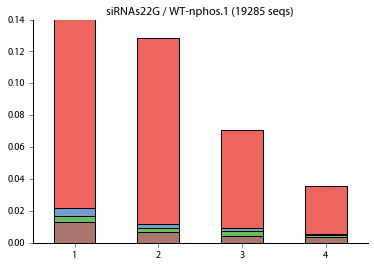

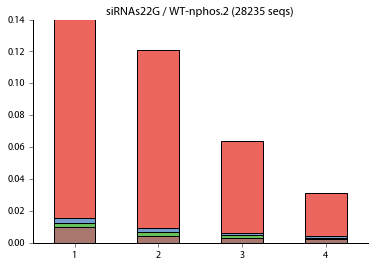

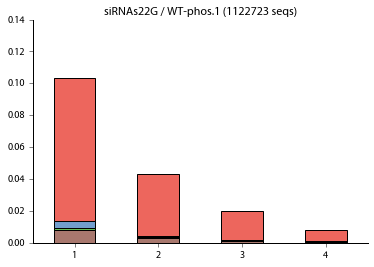

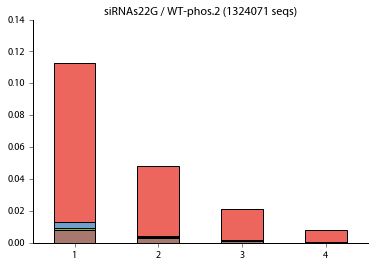

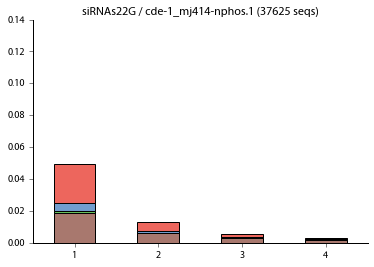

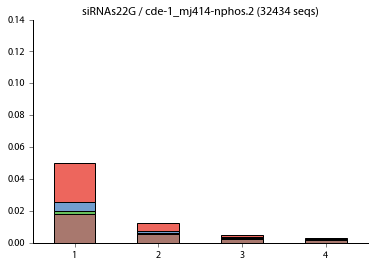

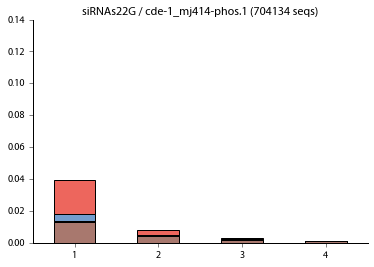

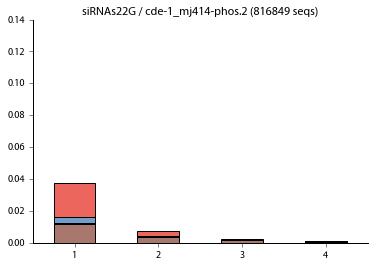

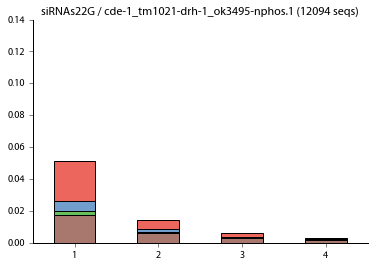

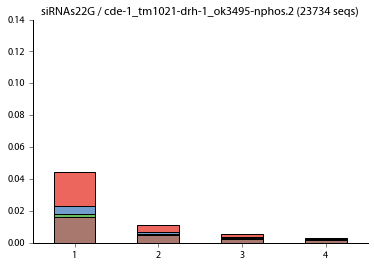

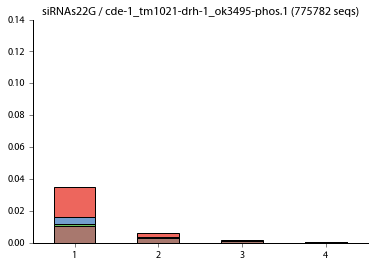

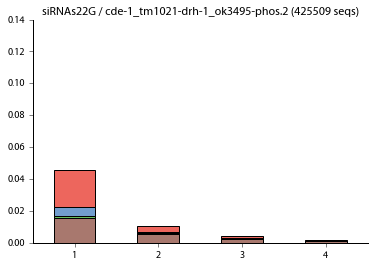

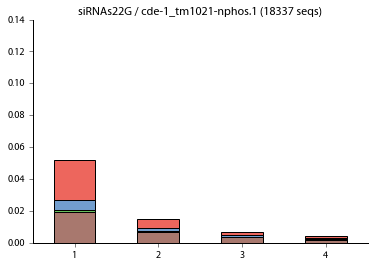

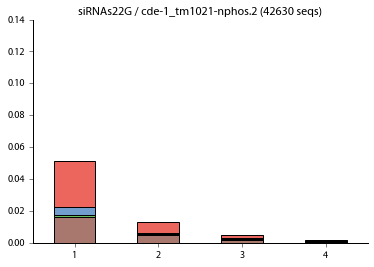

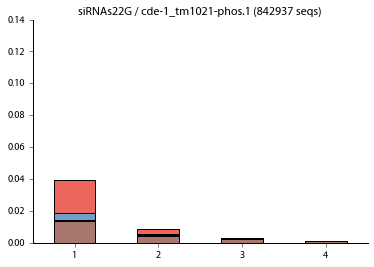

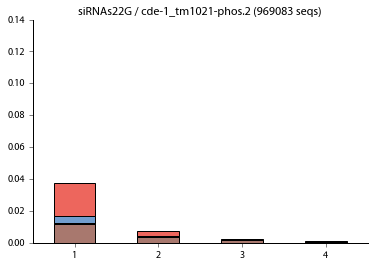

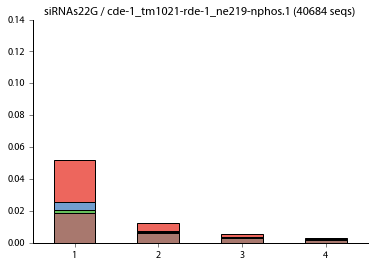

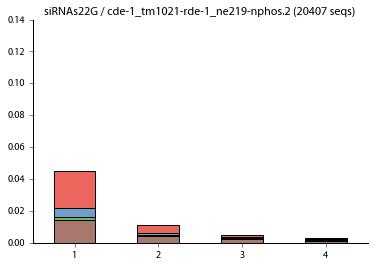

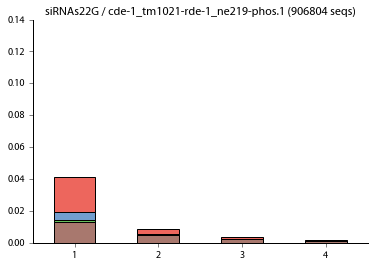

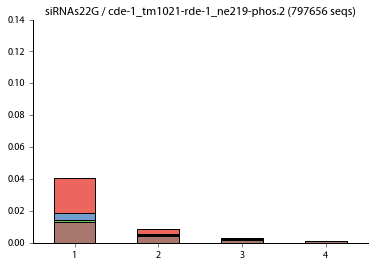

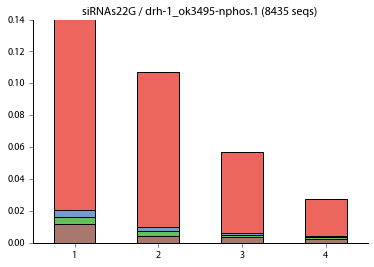

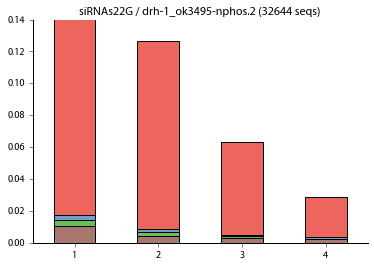

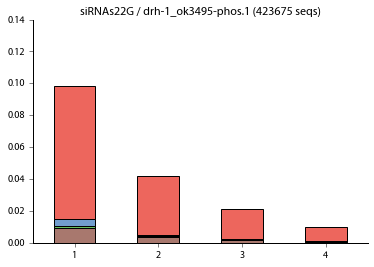

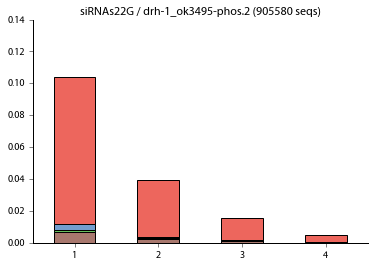

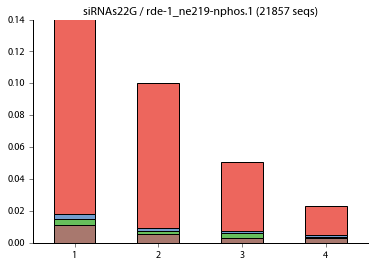

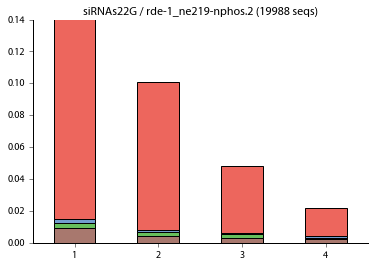

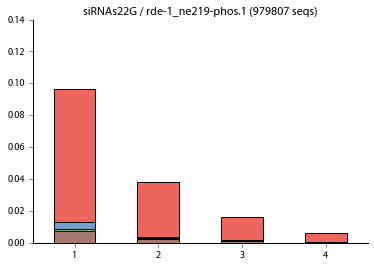

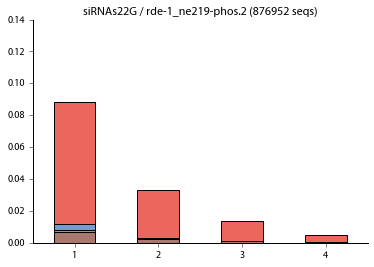

In [8]:
plot_results(wrnas,["siRNAs22G"],prefix="wRNAs_",ylim=0.14)

#### MicroRNAs

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


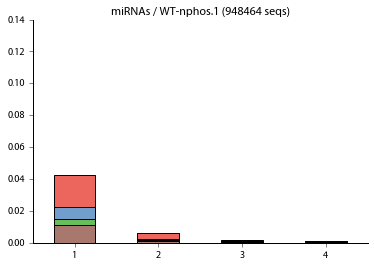

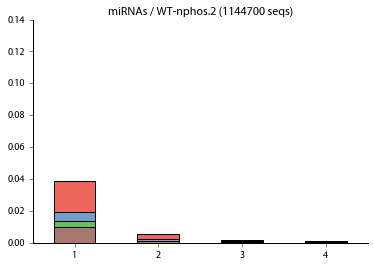

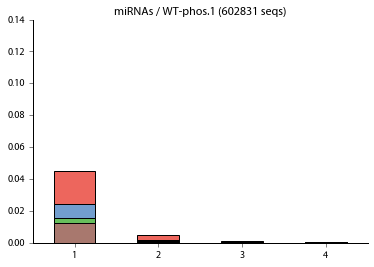

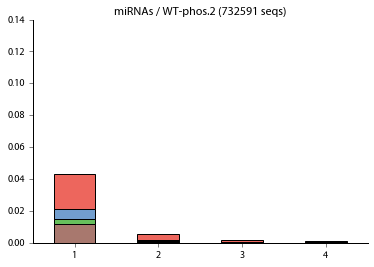

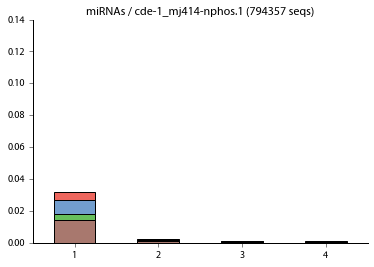

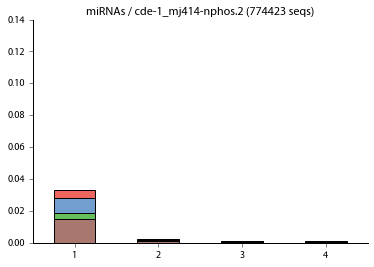

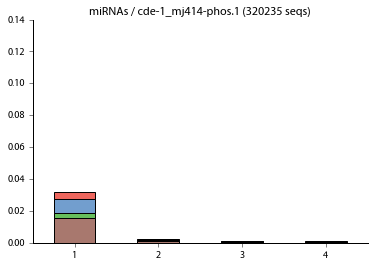

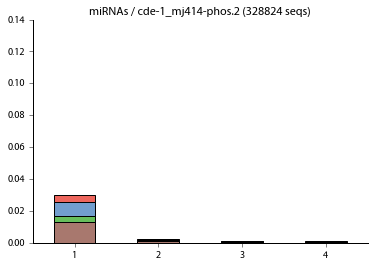

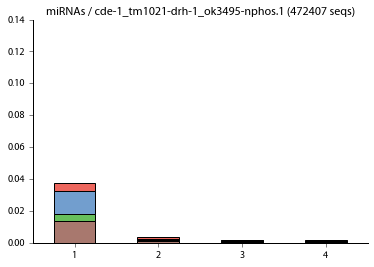

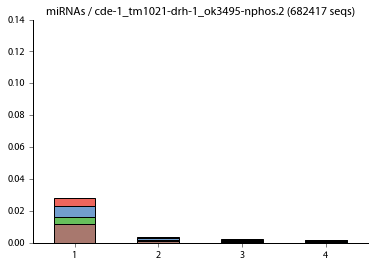

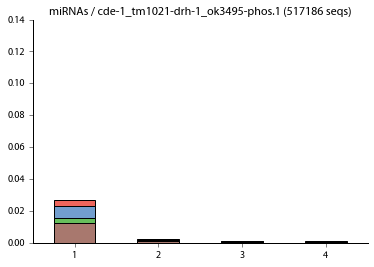

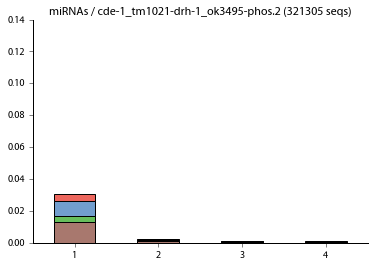

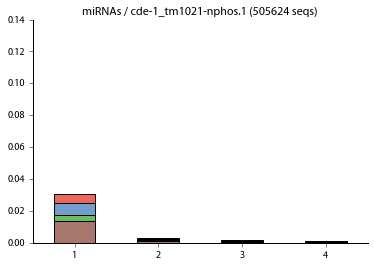

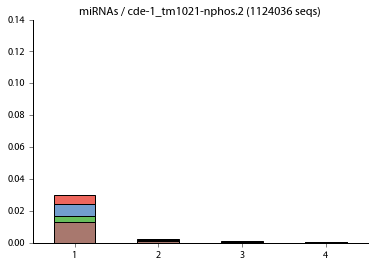

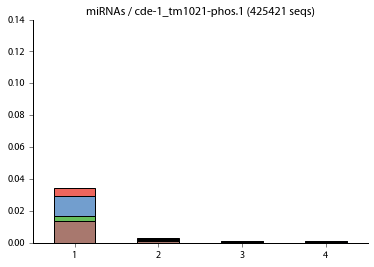

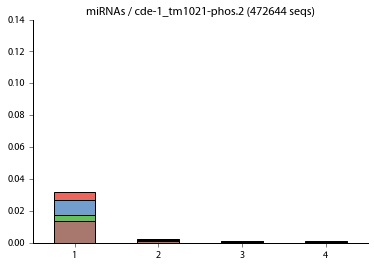

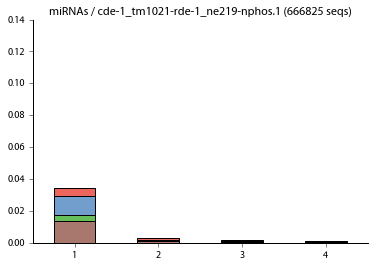

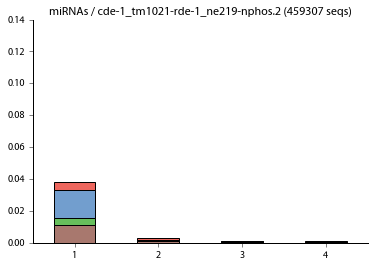

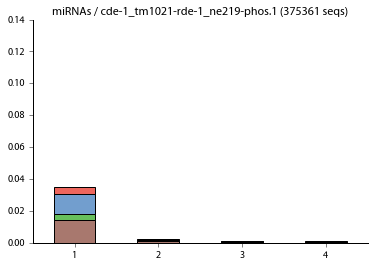

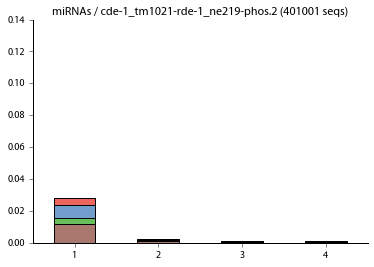

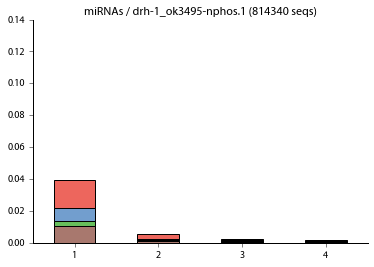

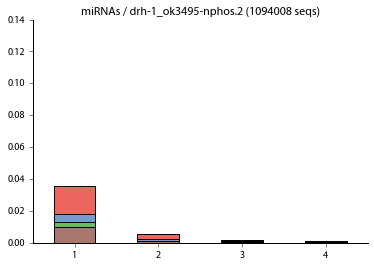

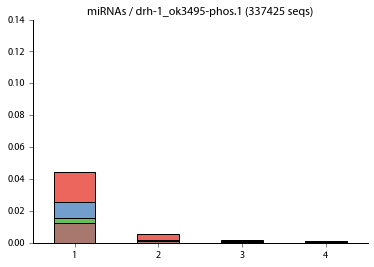

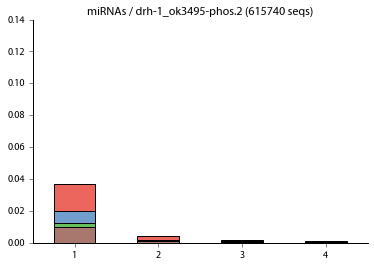

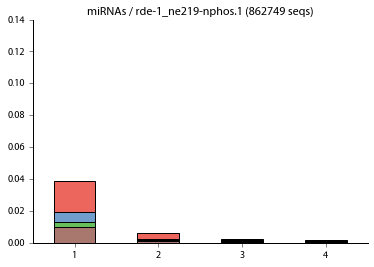

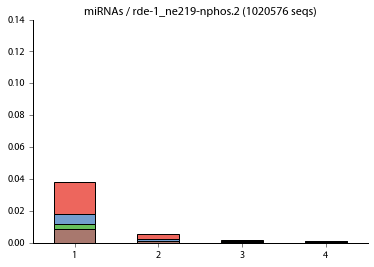

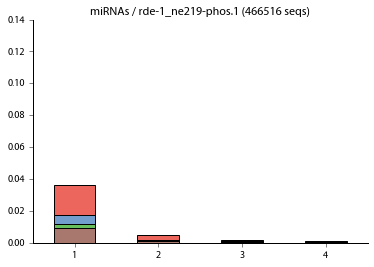

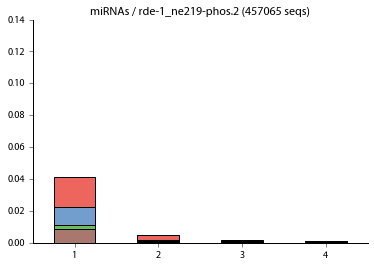

In [10]:
plot_results(wrnas,"miRNAs",prefix="wRNAs_",ylim=0.14)

#### piRNAs

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


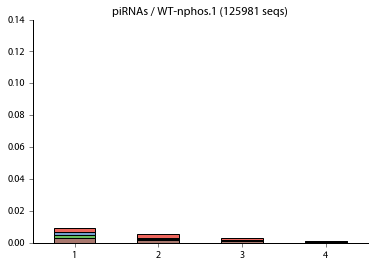

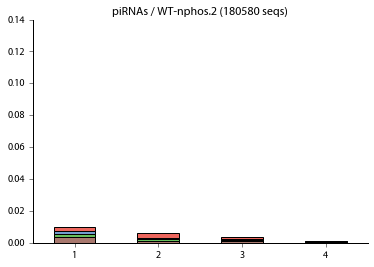

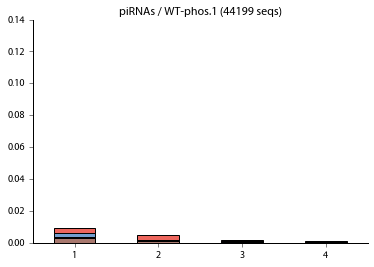

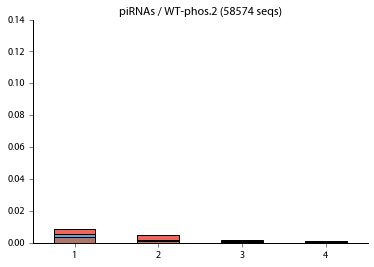

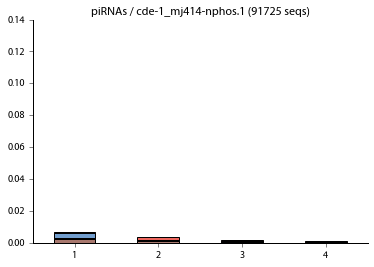

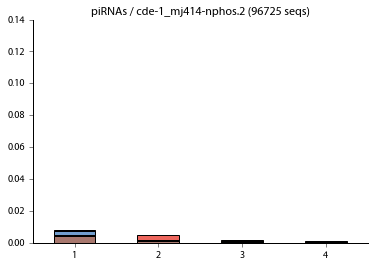

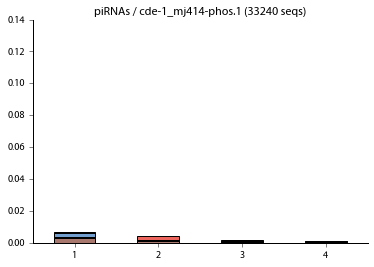

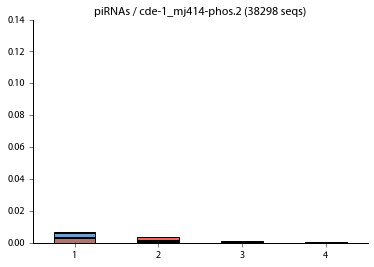

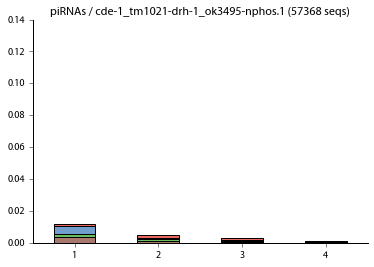

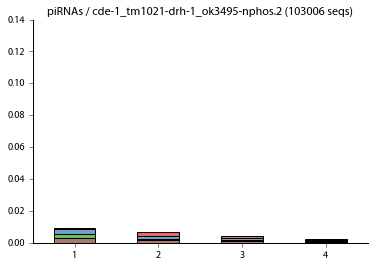

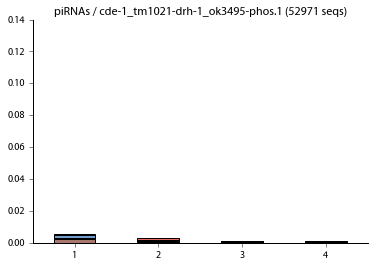

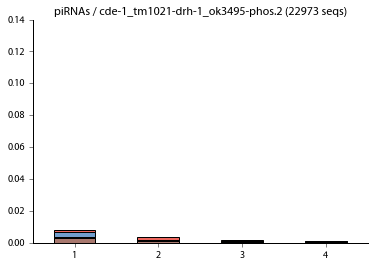

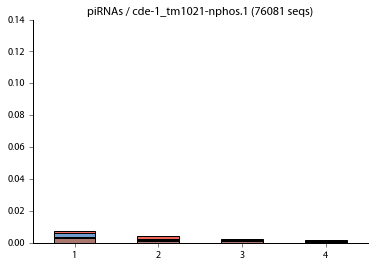

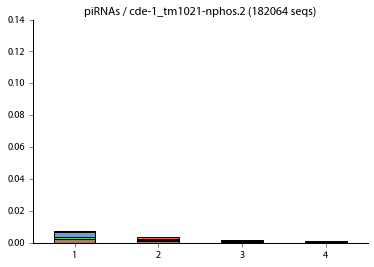

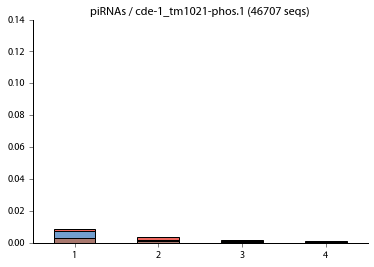

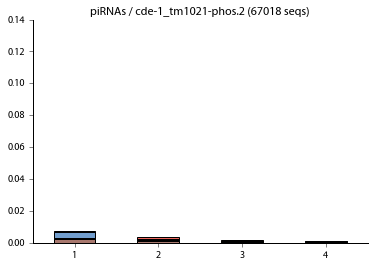

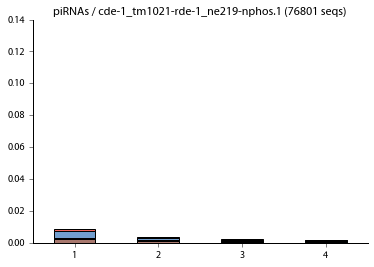

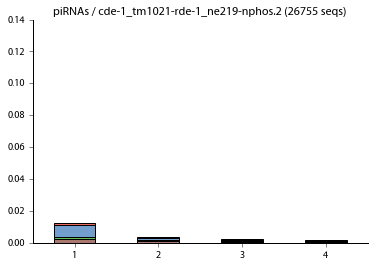

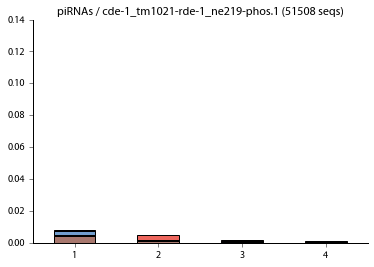

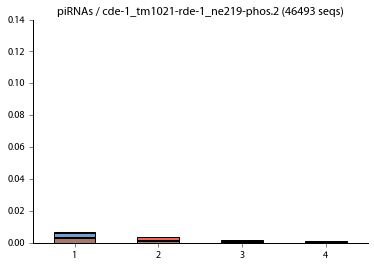

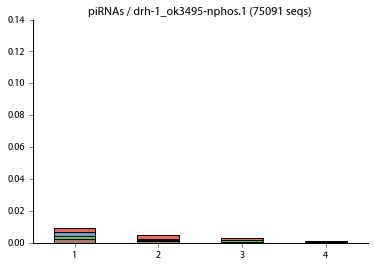

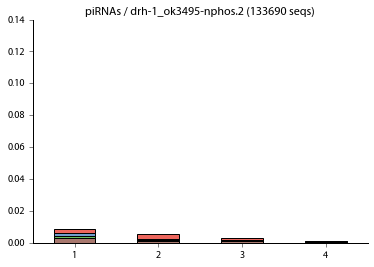

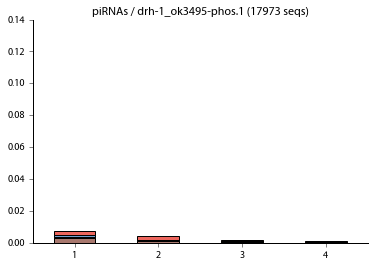

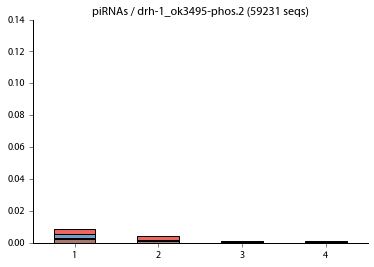

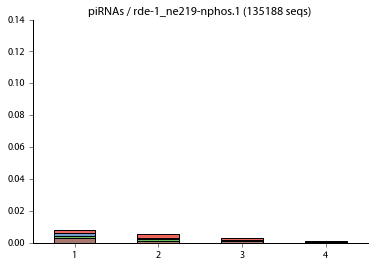

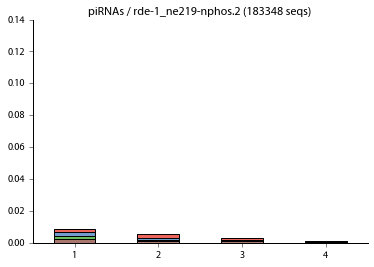

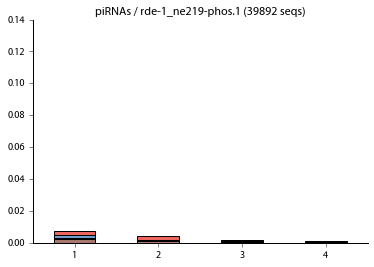

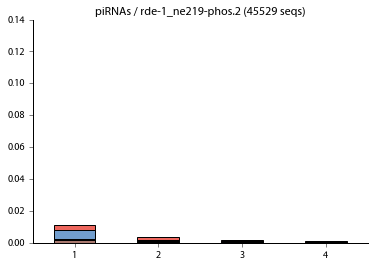

In [11]:
plot_results(wrnas,"piRNAs",prefix="wRNAs_",ylim=0.14)

### viRNAs
Small RNAs mapping to the viral genome

In [16]:
sids = [
    "cde-1_mj414-nphos",
    "cde-1_mj414-phos",
    "cde-1_tm1021-drh-1_ok3495-nphos",
    "cde-1_tm1021-drh-1_ok3495-phos",
    "cde-1_tm1021-nphos",
    "cde-1_tm1021-phos",
    "cde-1_tm1021-rde-1_ne219-nphos",
    "cde-1_tm1021-rde-1_ne219-phos",
    "drh-1_ok3495-nphos",
    "drh-1_ok3495-phos",
    "rde-1_ne219-nphos",
    "rde-1_ne219-phos",
    "WT-nphos",
    "WT-phos"
]
replicates = ["1","2"]

virnas = {cat:{"data":{"chrdata":None},"async":{"res":None,"done":False}} for cat in ["all","22G","dp22","dp23"]}

virnas["all"]["async"]["res"] = get_tails_srna.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname, "lengths":[21,22,23,24],'nt5p':None} for sid in sids for rep in replicates for chrname in chrnames_v])
virnas["22G"]["async"]["res"] = get_tails_srna.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname, "lengths":[22], 'nt5p':'G'} for sid in sids for rep in replicates for chrname in chrnames_v])
virnas["dp23"]["async"]["res"] = get_tails_dp.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":chrname,"lengths":[23],"offset":2} for sid in sids for rep in replicates for chrname in chrnames_v])

In [ ]:
#wait for all results to be ready and persist to a json file
import time
while True:
    time.sleep(60)
    if virnas["all"]["async"]["res"].ready() == True and  virnas["22G"]["async"]["res"].ready() == True and  virnas["dp23"]["async"]["res"].ready() == True:
        virnas = reshape_remote(virnas)
        break

for cat in virnas:
    virnas[cat]["async"] = {"res":None,"done":True}
    
with open("out/json/virnas_tailing.json","w") as fo:
    fo.write(json.dumps(virnas))

In [8]:
with open("out/json/virnas_tailing.json") as f:
    virnas = json.load(f)

#### all (21-24nt)

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


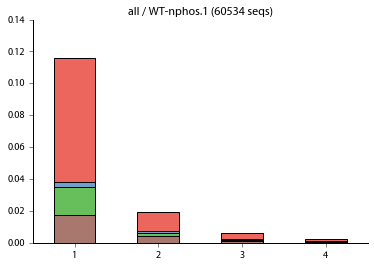

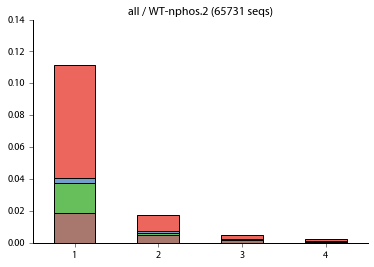

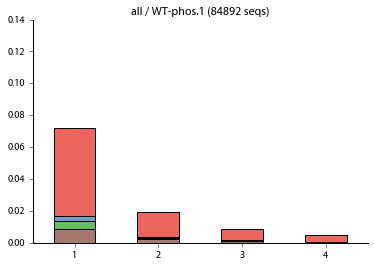

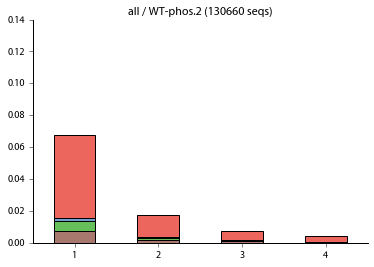

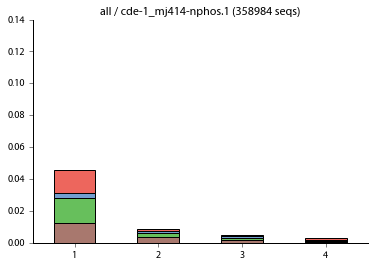

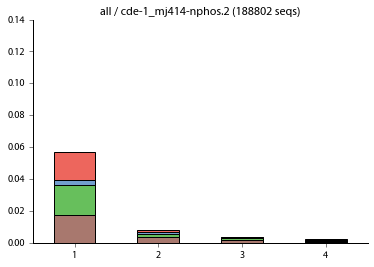

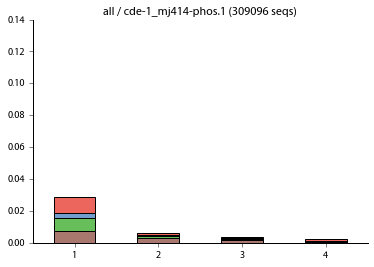

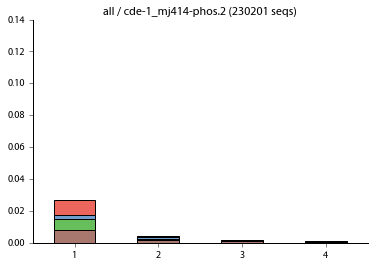

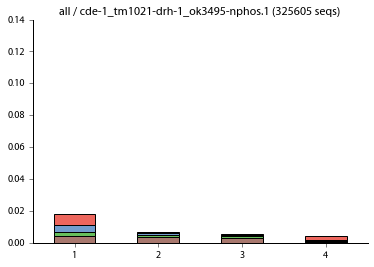

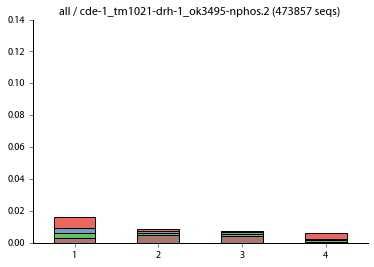

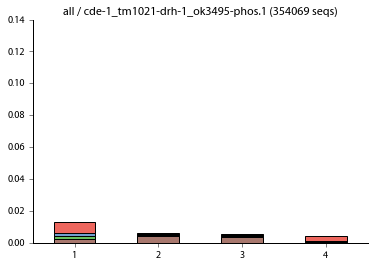

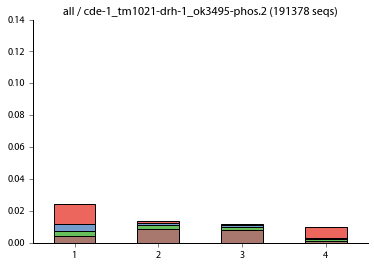

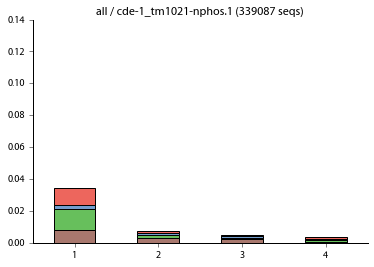

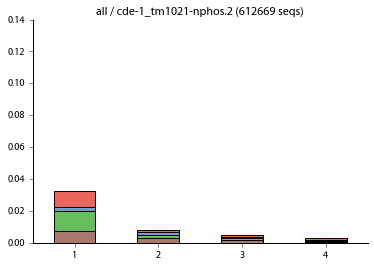

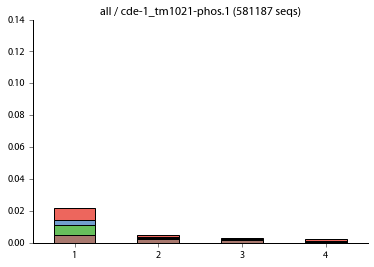

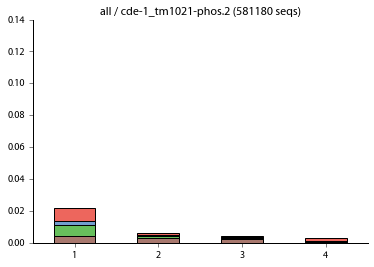

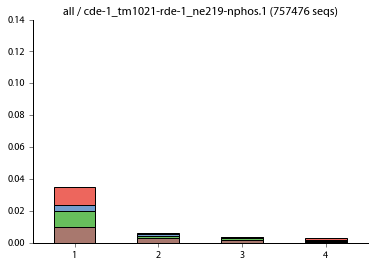

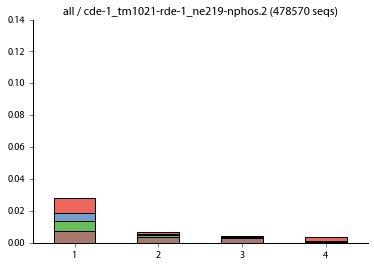

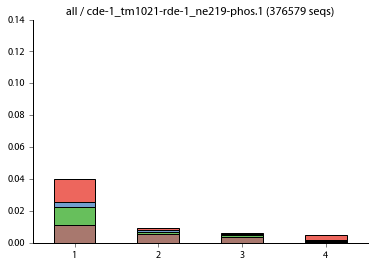

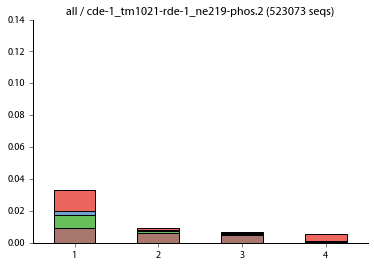

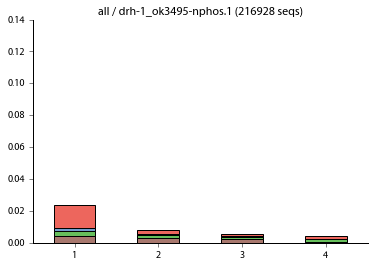

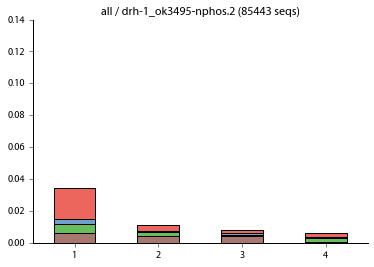

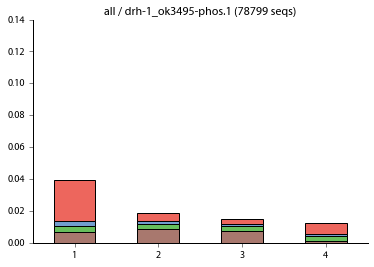

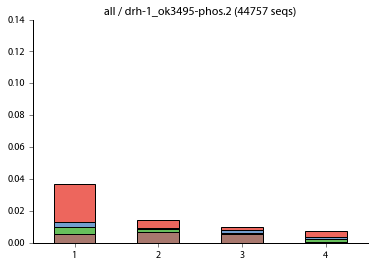

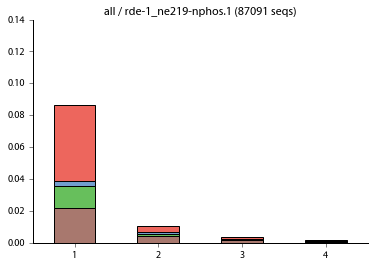

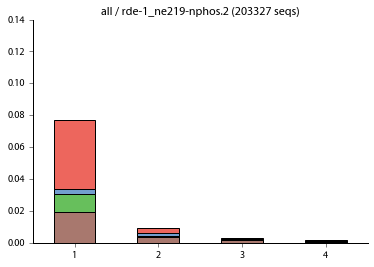

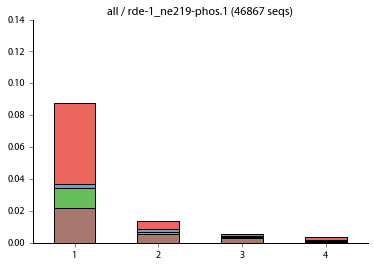

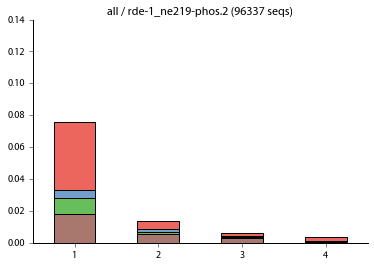

In [13]:
plot_results(virnas,"all",prefix="vRNAs_",ylim=0.14,destrand=True)

#### dicer products

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


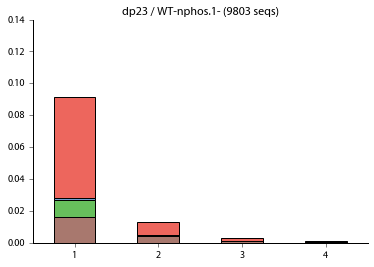

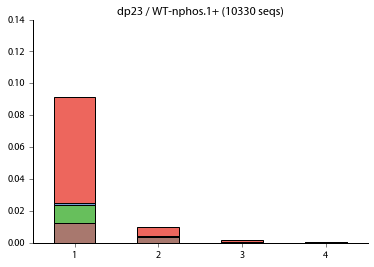

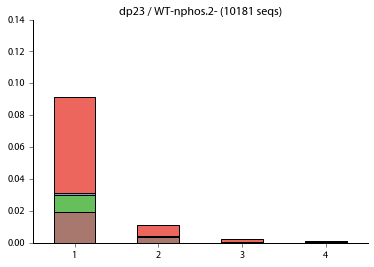

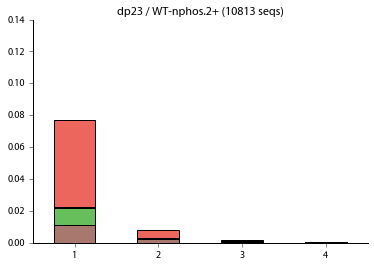

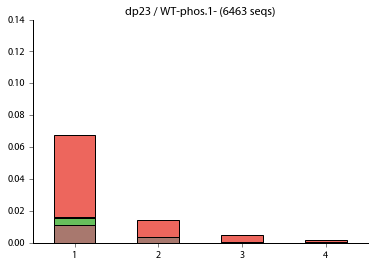

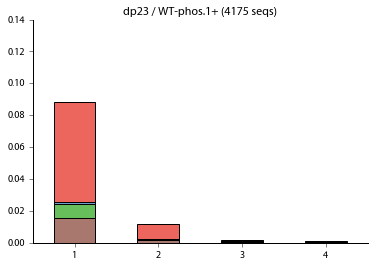

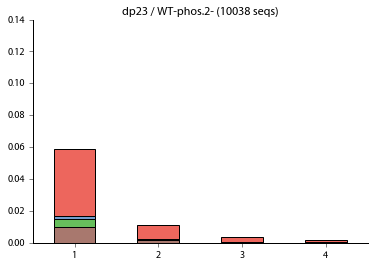

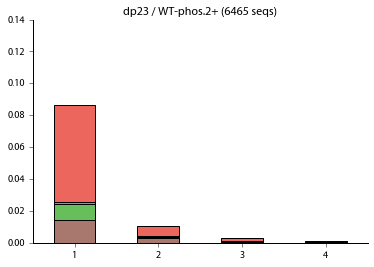

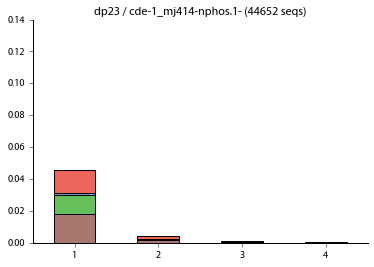

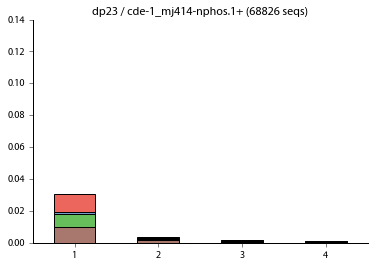

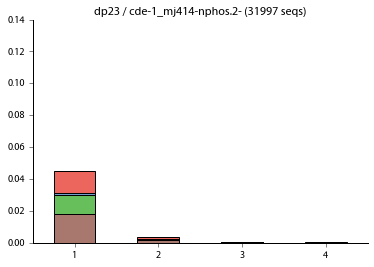

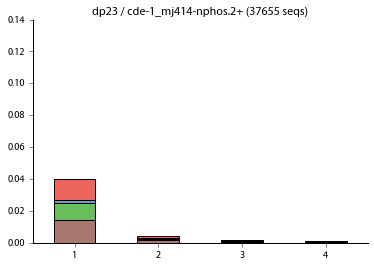

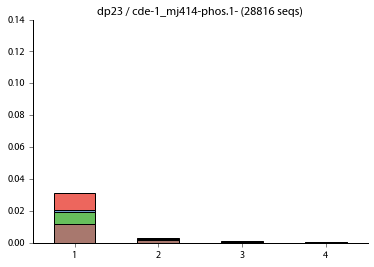

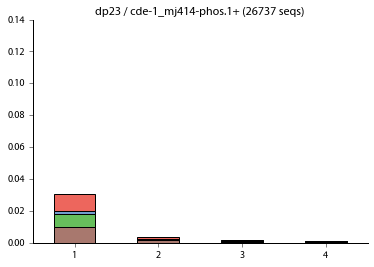

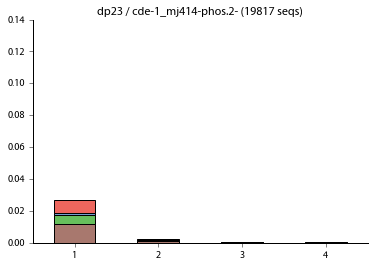

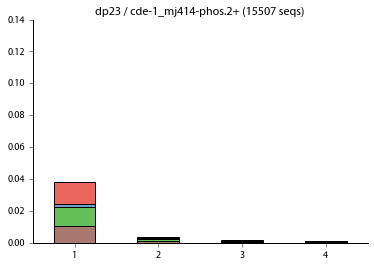

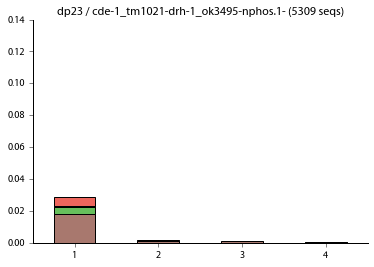

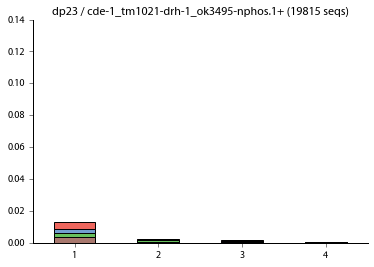

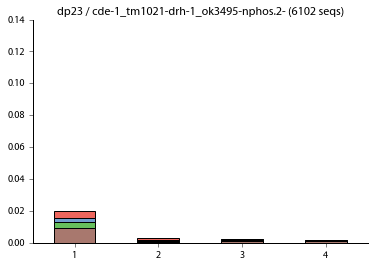

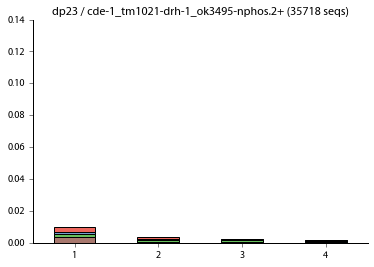

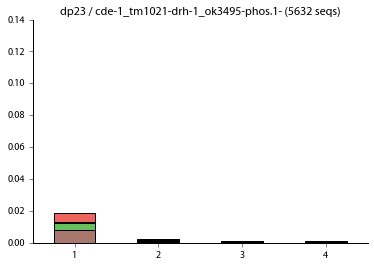

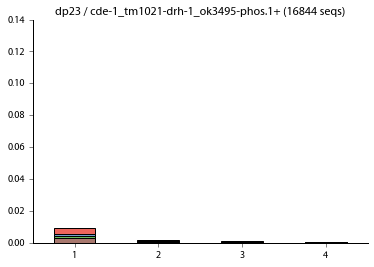

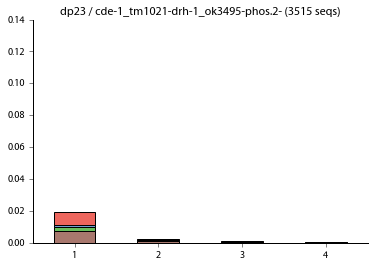

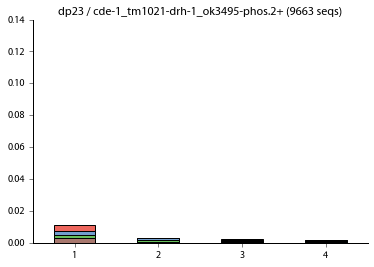

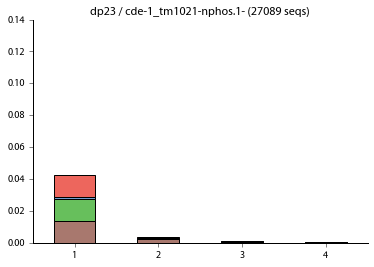

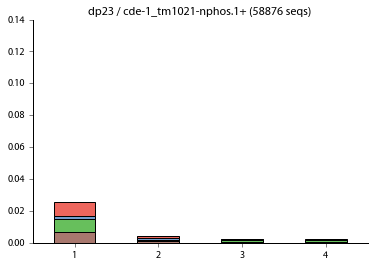

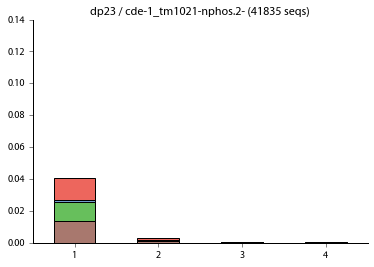

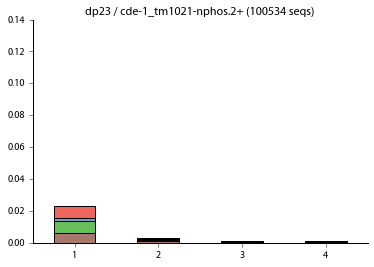

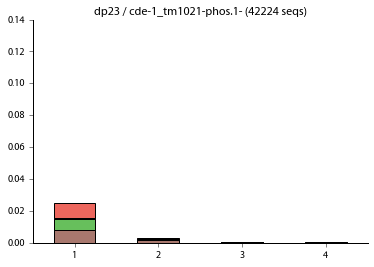

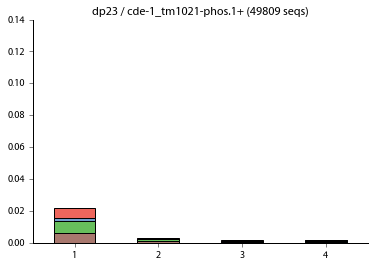

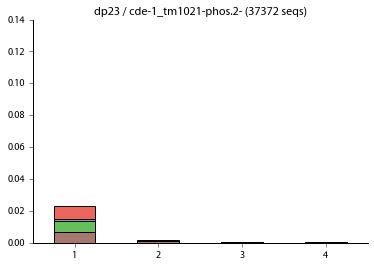

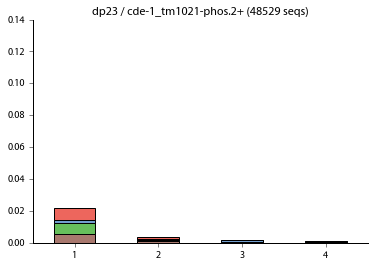

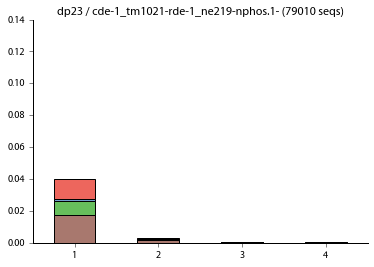

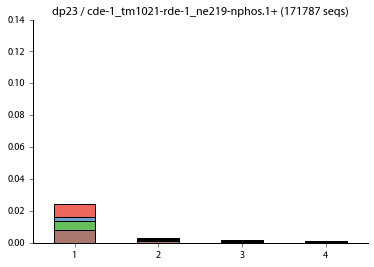

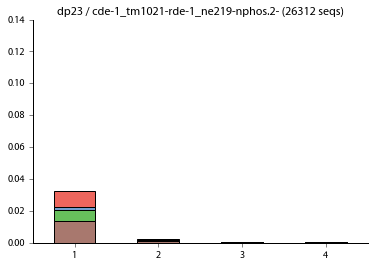

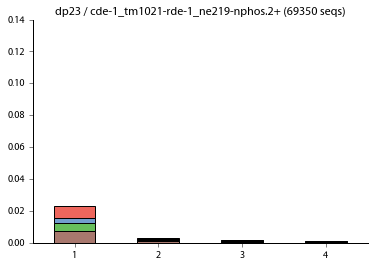

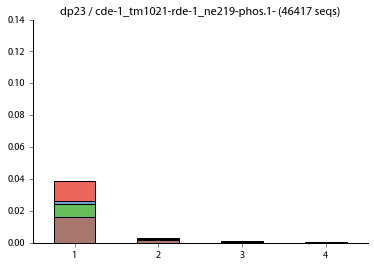

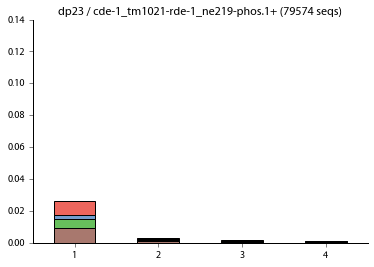

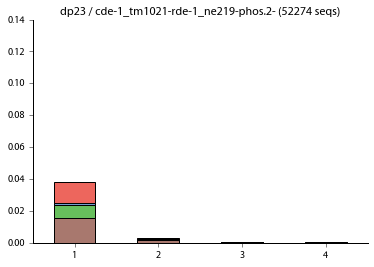

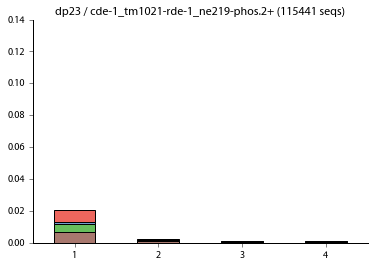

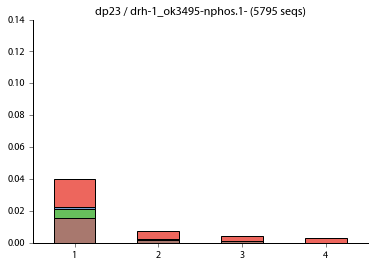

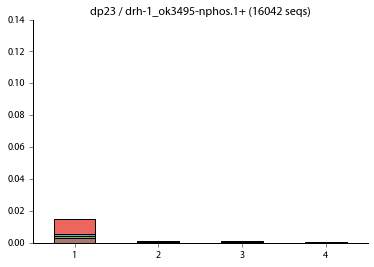

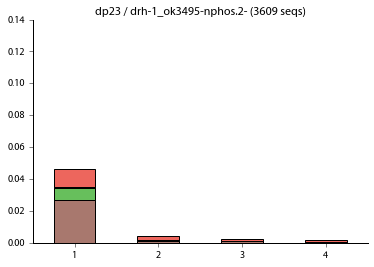

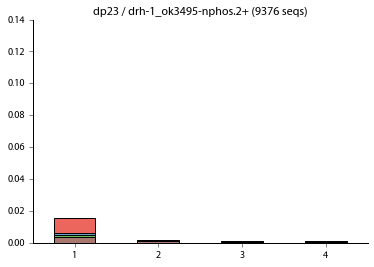

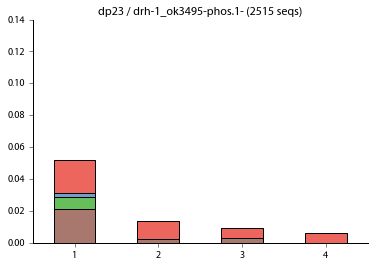

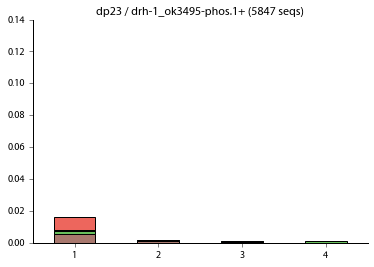

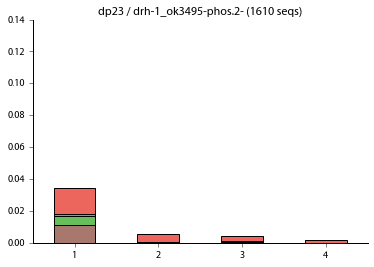

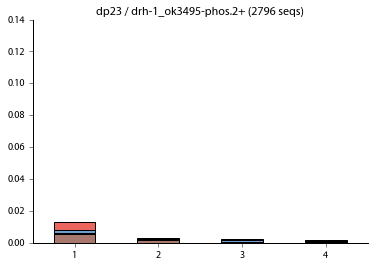

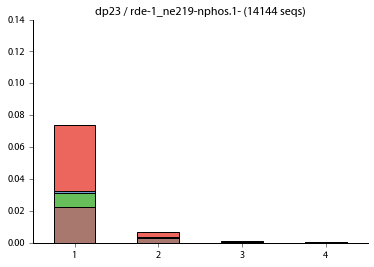

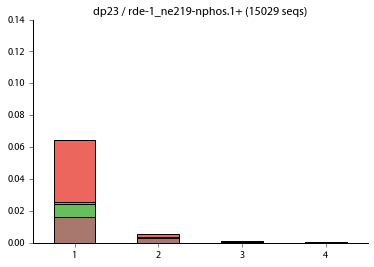

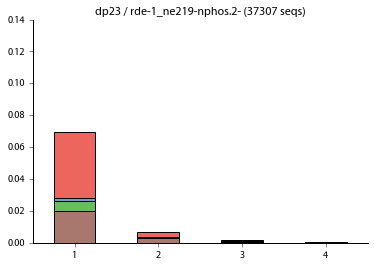

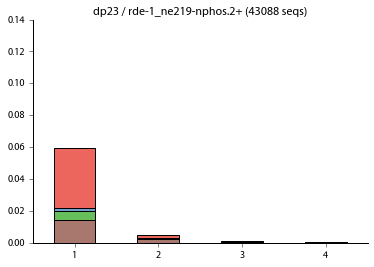

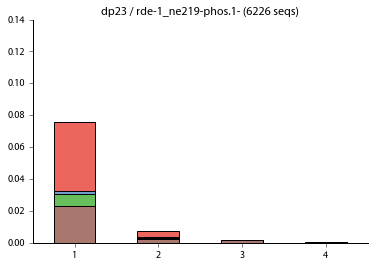

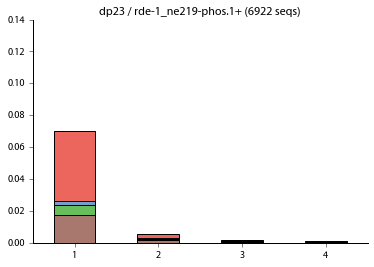

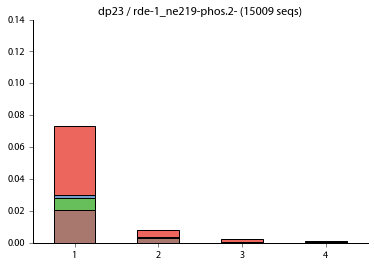

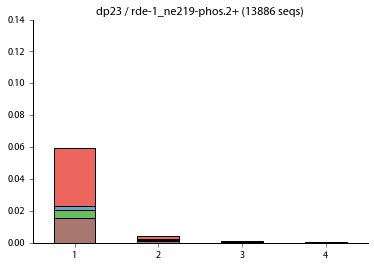

In [14]:
plot_results(virnas,["dp23"],prefix="vRNAs_",ylim=0.14,destrand=True)

#### 22G

/home/tdido/apps/miniconda3/envs/nbooks/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


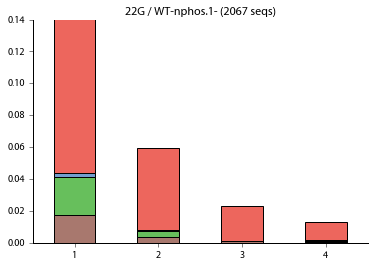

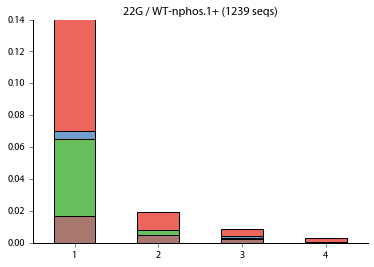

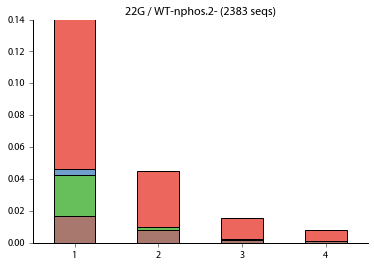

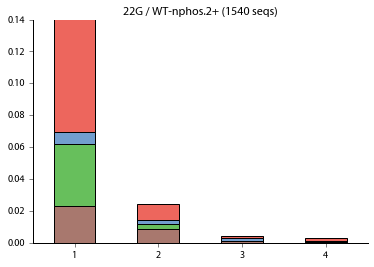

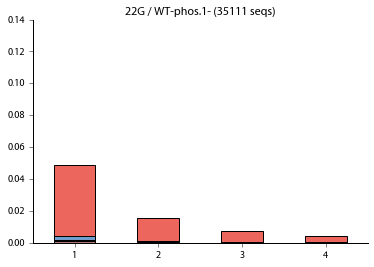

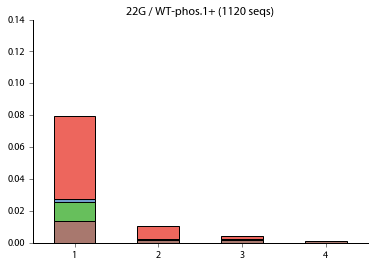

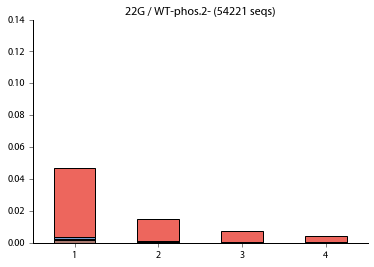

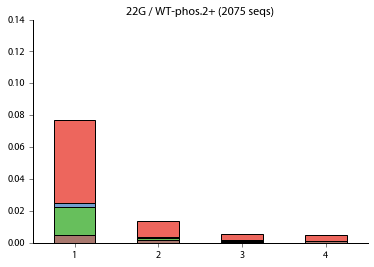

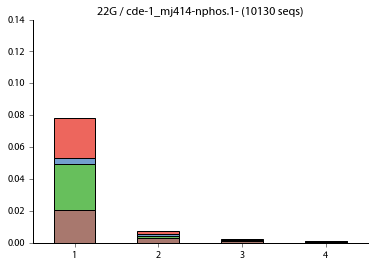

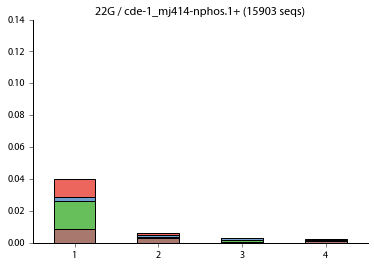

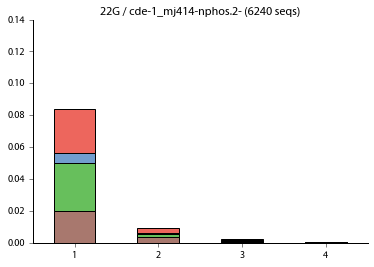

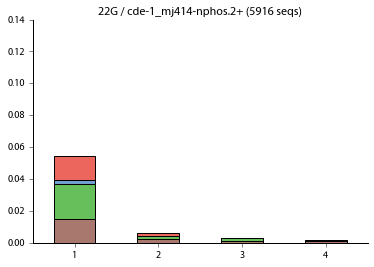

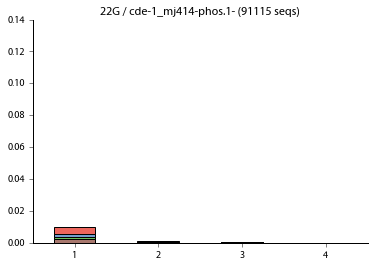

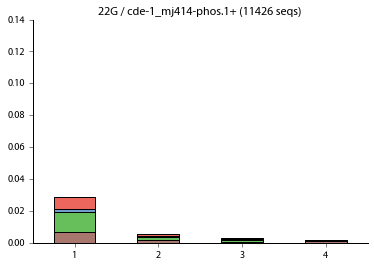

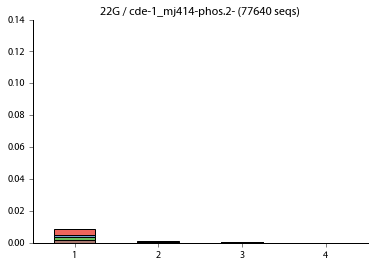

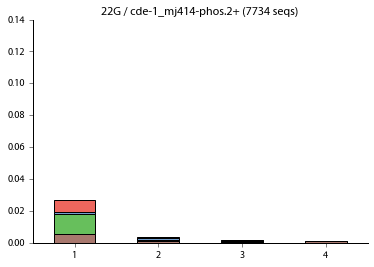

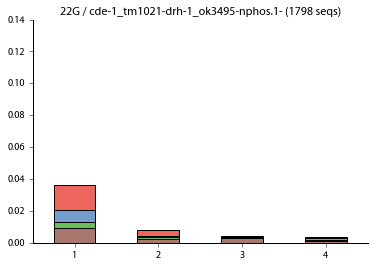

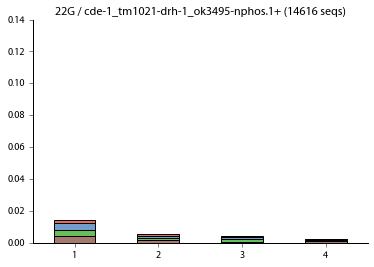

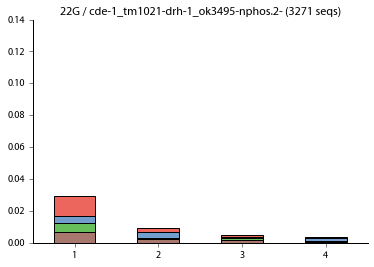

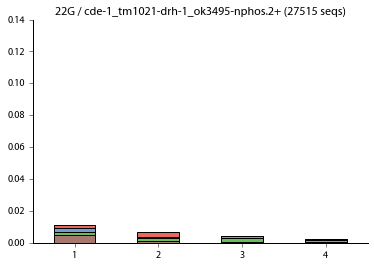

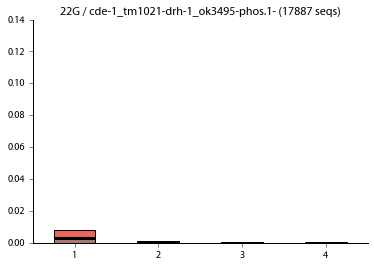

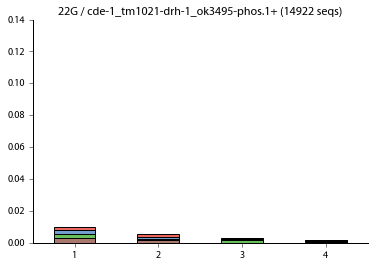

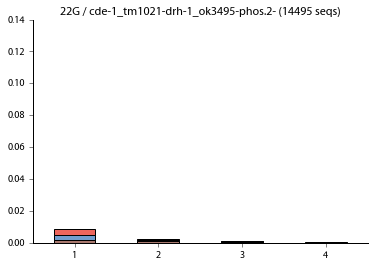

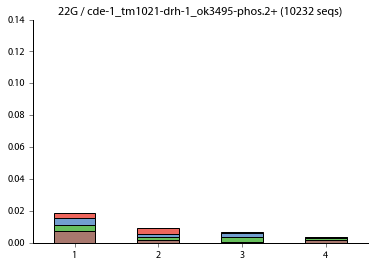

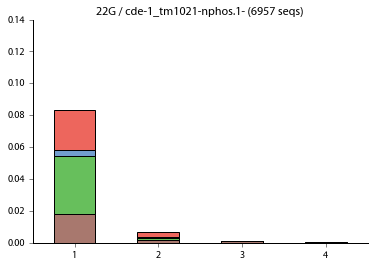

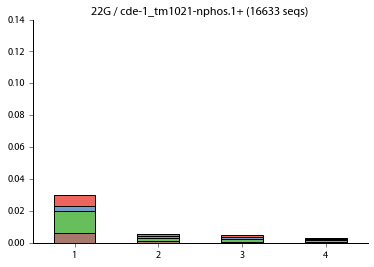

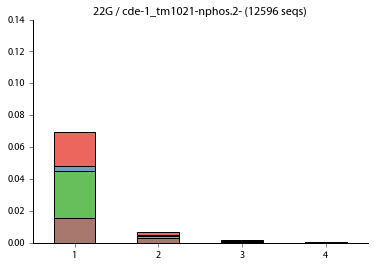

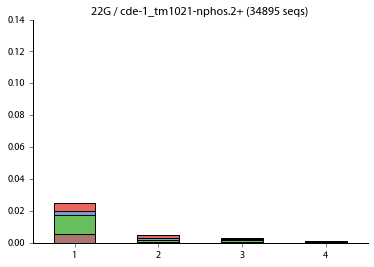

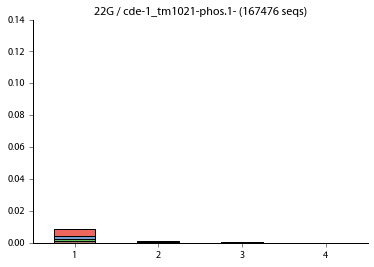

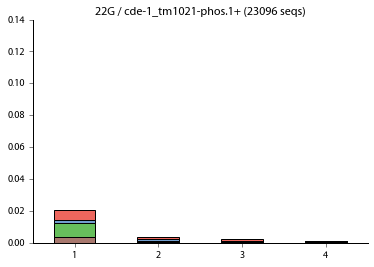

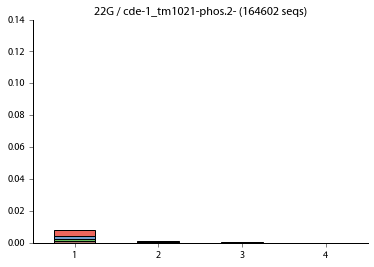

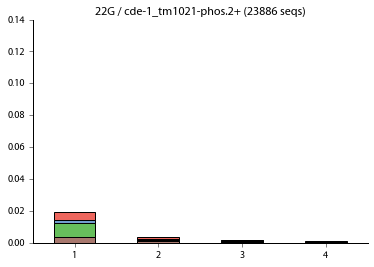

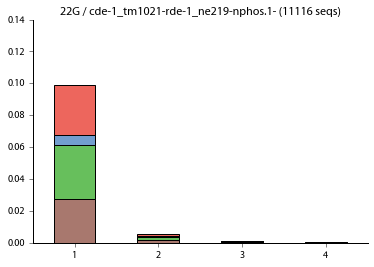

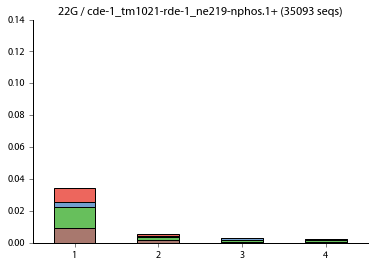

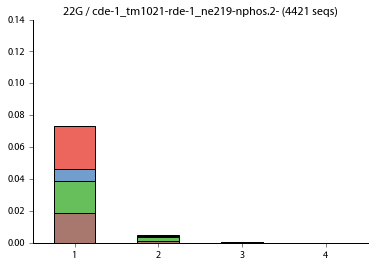

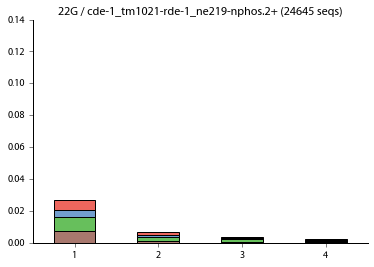

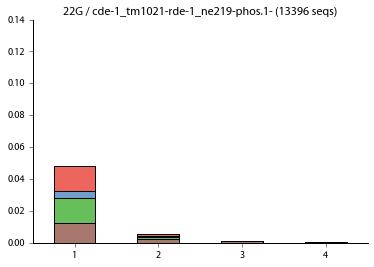

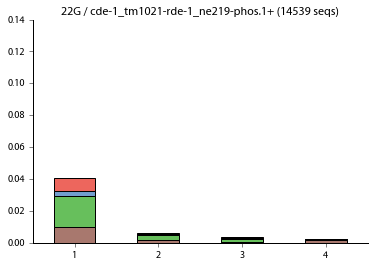

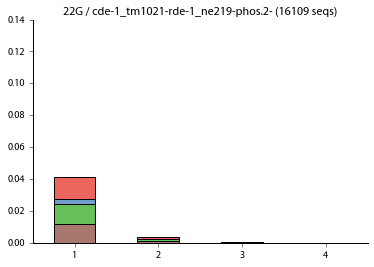

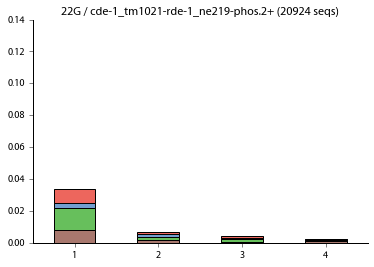

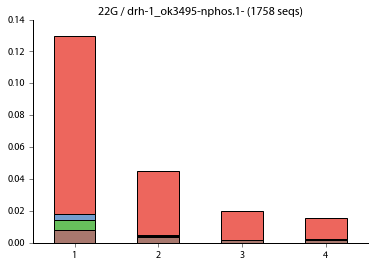

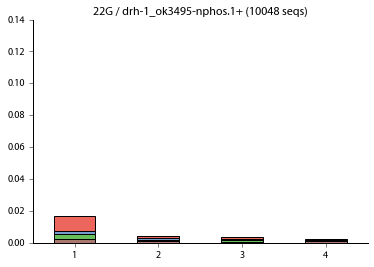

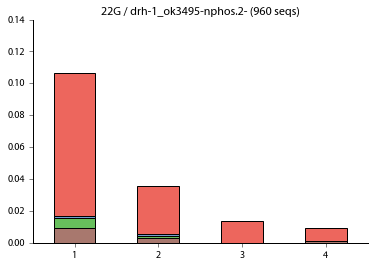

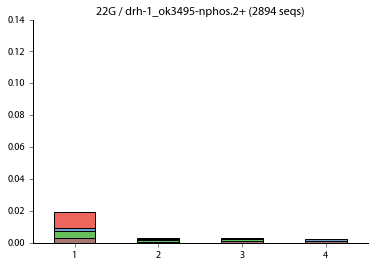

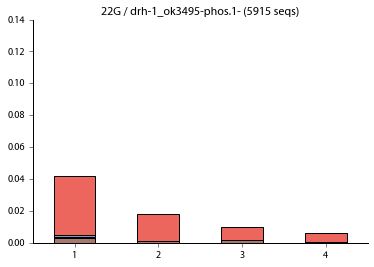

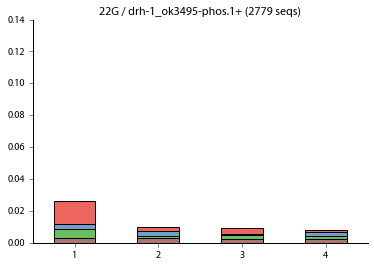

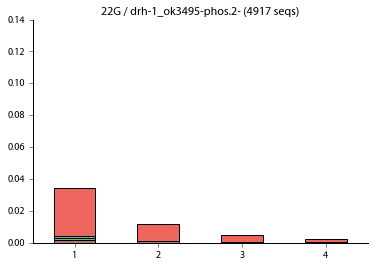

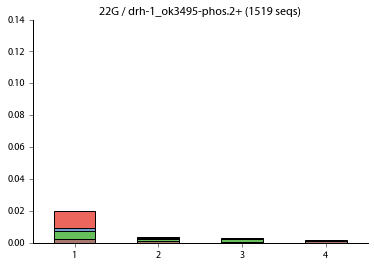

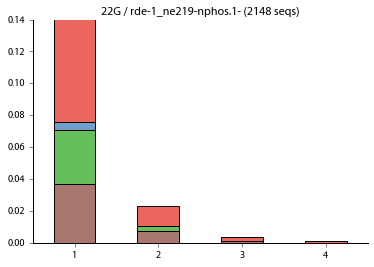

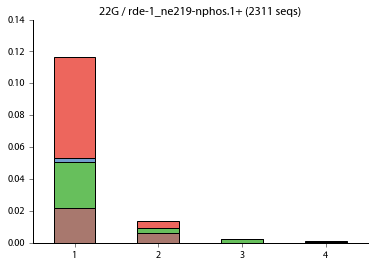

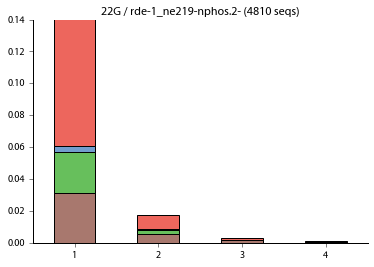

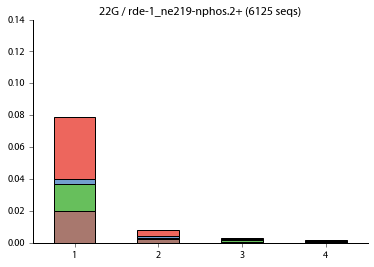

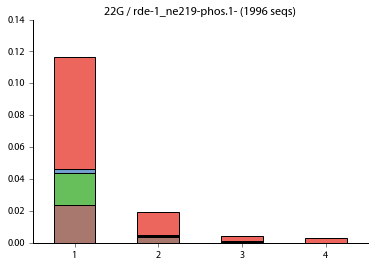

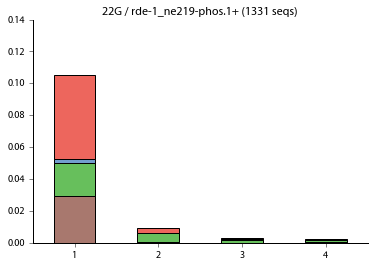

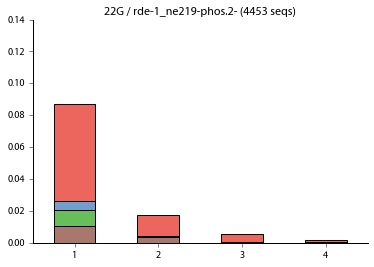

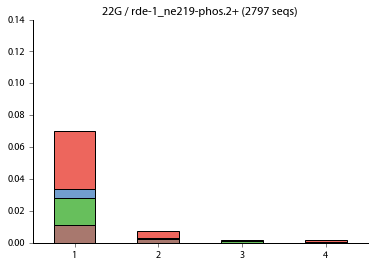

In [15]:
plot_results(virnas,"22G",prefix="vRNAs_",ylim=0.14)

#### peterplots

In [18]:
@dview.parallel(block=False)
def getcounts(params):
    sid = params["sid"]
    rep = params["rep"]
    minlength = params["minlength"]
    maxlength = params["maxlength"]
    stranded = params["stranded"]
        
    fpath = "{}/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam"
    fpath = fpath.format(ROOTRMT)
    
    from tstk import peterplot as pp
    counts = pp.getcounts(fpath,minlength=minlength,chrnames=["RNA1","RNA2"],maxlength=maxlength,stranded=stranded)
    return {"sid":sid,"rep":rep,"counts":counts}

In [9]:
sids_phos = [
    "cde-1_mj414-phos",
    "cde-1_tm1021-drh-1_ok3495-phos",
    "cde-1_tm1021-phos",
    "cde-1_tm1021-rde-1_ne219-phos",
    "drh-1_ok3495-phos",
    "rde-1_ne219-phos",
    "WT-phos"
]
sids_nphos=[
    "cde-1_mj414-nphos",
    "cde-1_tm1021-drh-1_ok3495-nphos",
    "cde-1_tm1021-nphos",
    "cde-1_tm1021-rde-1_ne219-nphos",
    "drh-1_ok3495-nphos",
    "rde-1_ne219-nphos",
    "WT-nphos"
]

replicates = ["1","2"]
minlength = 21
maxlength = 25

#non normalised counts, custom normalisation to follow
counts_remote_nphos = getcounts.map([{"sid":sid,"rep":rep,"minlength":minlength,"maxlength":maxlength,"stranded":True} for sid in sids_nphos for rep in replicates])
counts_remote_phos = getcounts.map([{"sid":sid,"rep":rep,"minlength":minlength,"maxlength":maxlength,"stranded":True} for sid in sids_phos for rep in replicates])

In [23]:
if counts_remote_nphos.ready() and counts_remote_phos.ready():
    counts_nphos = counts_remote_nphos.get()
    counts_phos = counts_remote_phos.get()
    %store counts_nphos
    %store counts_phos
    print("done")
else:
    print("not yet")

Stored 'counts_nphos' (list)
Stored 'counts_phos' (list)
done


In [7]:
%store -r counts_nphos
%store -r counts_phos

In [10]:
#normalise phos fw to total phos fw
#normalise all the rest to total
fwtotals = {sid:{rep:0 for rep in replicates} for sid in sids_phos}
totals = {sid:{rep:0 for rep in replicates} for sid in sids_phos+sids_nphos}

for result in counts_phos:
    sidtmp = result["sid"]
    reptmp = result["rep"]
    for length in result["counts"]["fw"]:
        for nuc in result["counts"]["fw"][length]:
            fwtotals[sidtmp][reptmp] += result["counts"]["fw"][length][nuc]
            
for result in counts_phos+counts_nphos:
    sidtmp = result["sid"]
    reptmp = result["rep"]
    for strand in result["counts"]:
        for length in result["counts"][strand]:
            for nuc in result["counts"][strand][length]:
                totals[sidtmp][reptmp] += result["counts"][strand][length][nuc]
            
for result in counts_phos:
    sidtmp = result["sid"]
    reptmp = result["rep"]
    for strand in result["counts"]:
        for length in result["counts"][strand]:
            for nuc in result["counts"][strand][length]:
                if strand == "fw":
                    result["counts"][strand][length][nuc] /= fwtotals[sidtmp][reptmp]
                else:
                    result["counts"][strand][length][nuc] /= totals[sidtmp][reptmp]
            
for result in counts_nphos:
    sidtmp = result["sid"]
    reptmp = result["rep"]
    for strand in result["counts"]:
        for length in result["counts"][strand]:
            for nuc in result["counts"][strand][length]:
                result["counts"][strand][length][nuc] /= totals[sidtmp][reptmp]

In [11]:
counts = counts_nphos + counts_phos

/home/tdido/apps/miniconda3/envs/cde-1/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


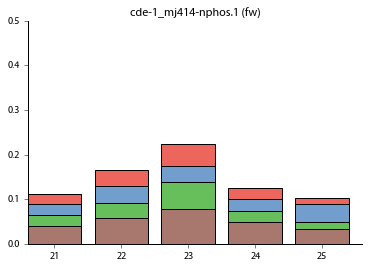

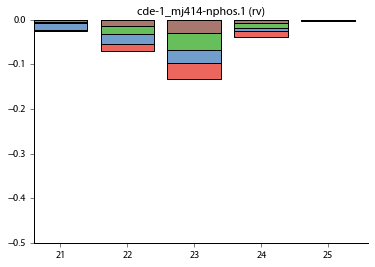

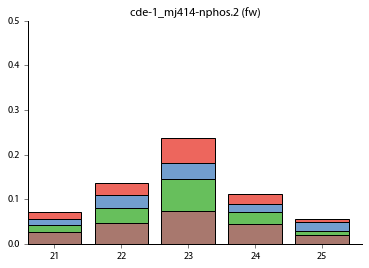

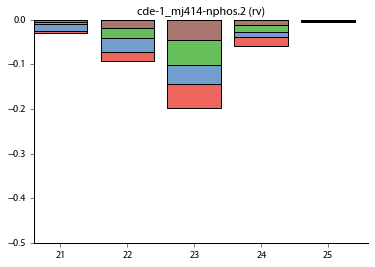

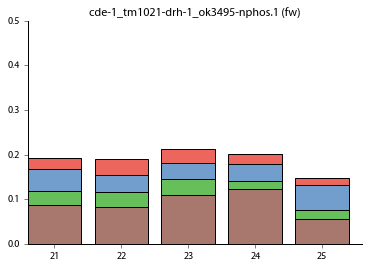

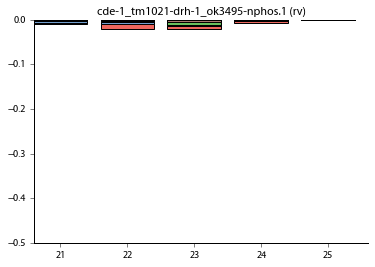

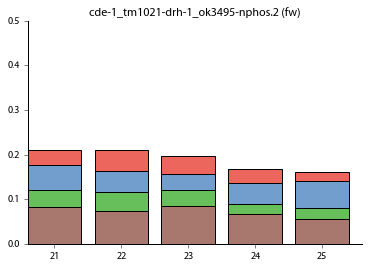

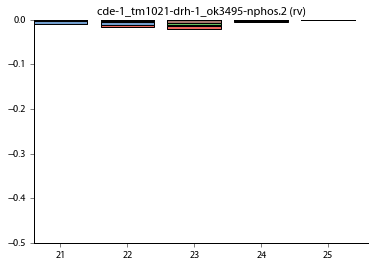

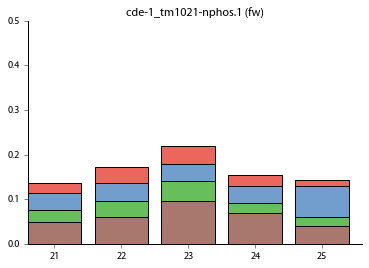

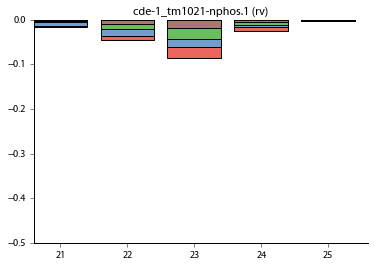

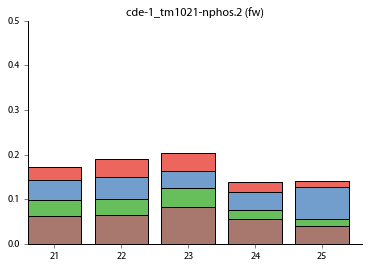

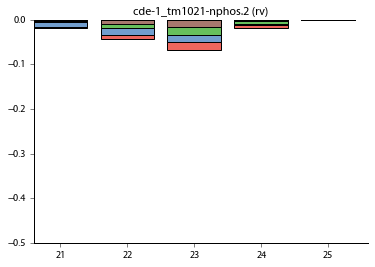

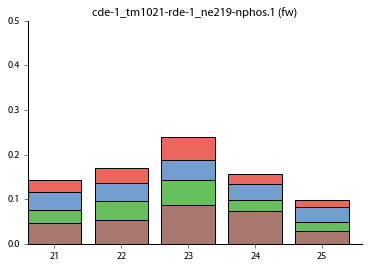

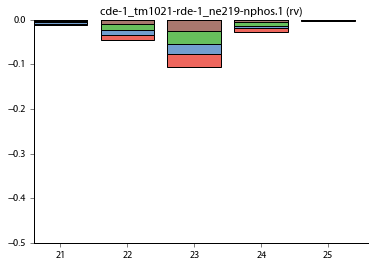

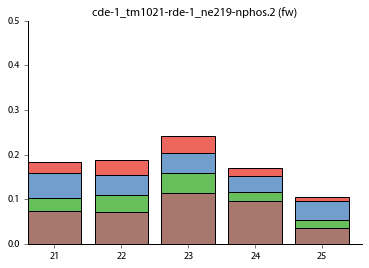

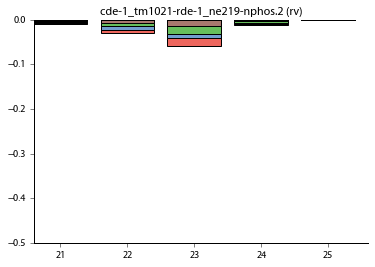

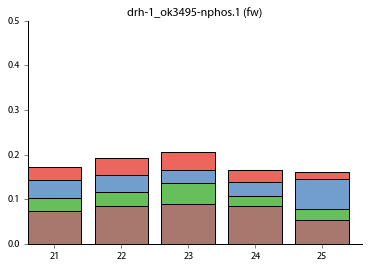

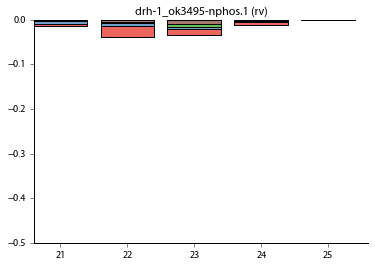

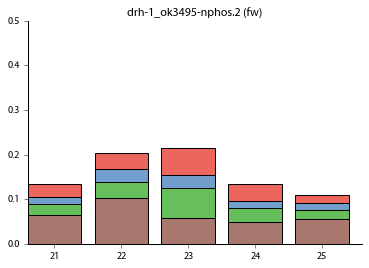

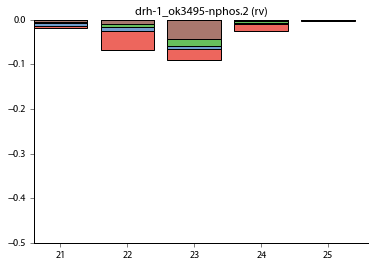

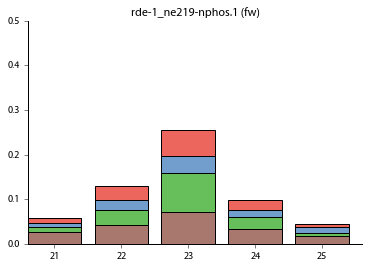

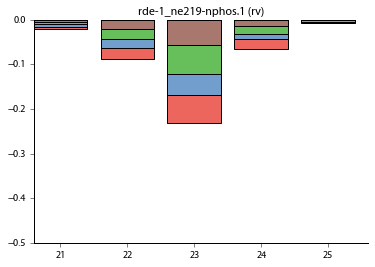

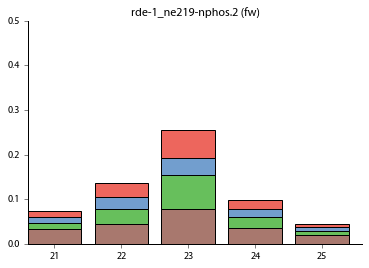

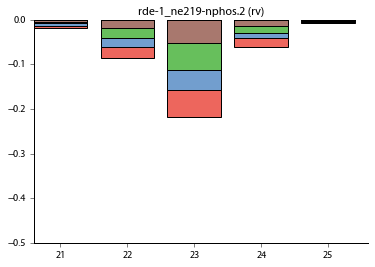

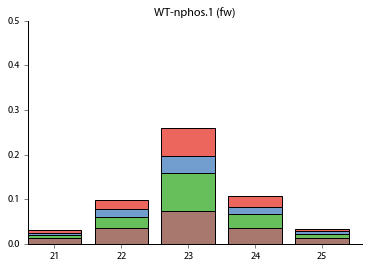

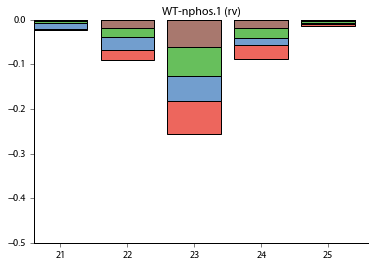

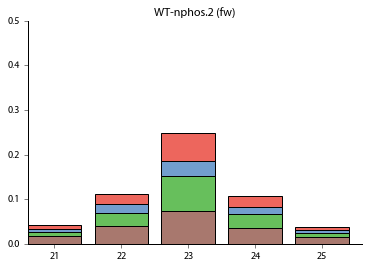

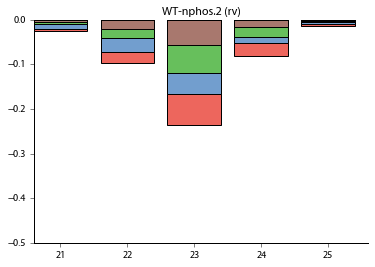

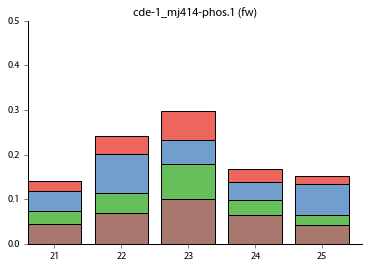

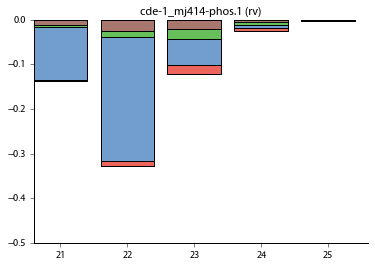

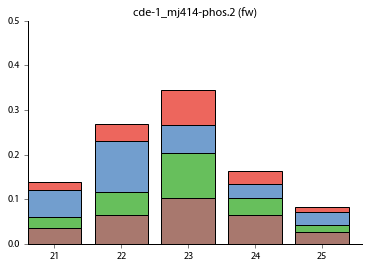

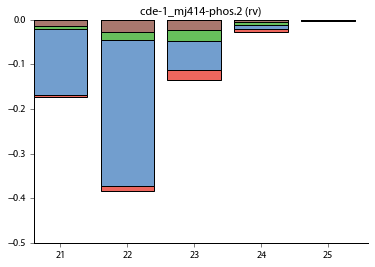

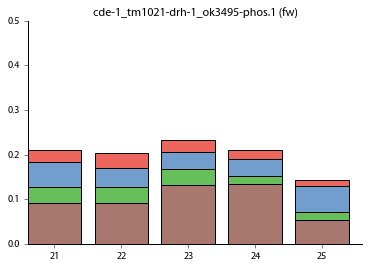

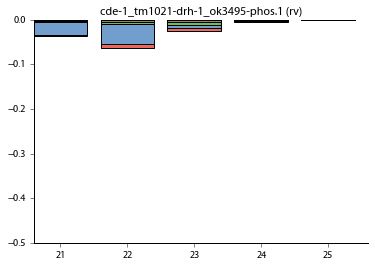

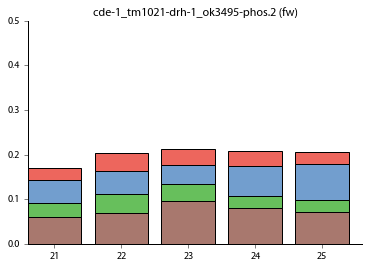

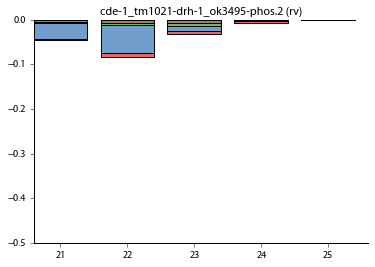

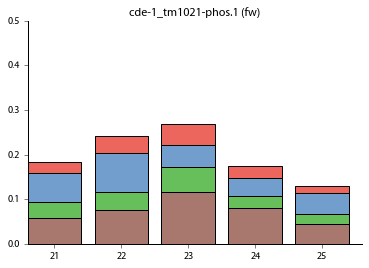

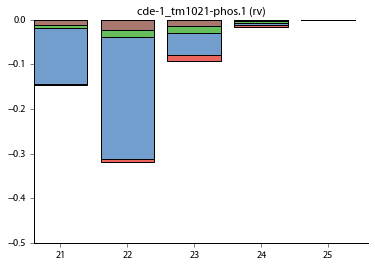

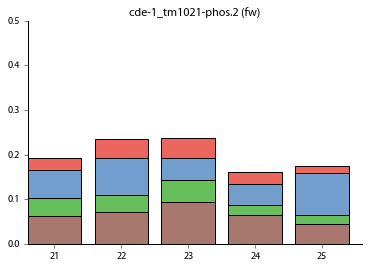

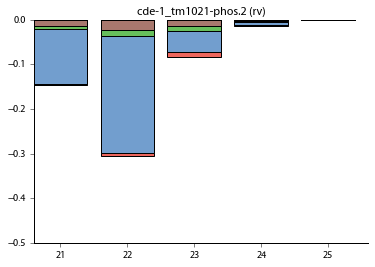

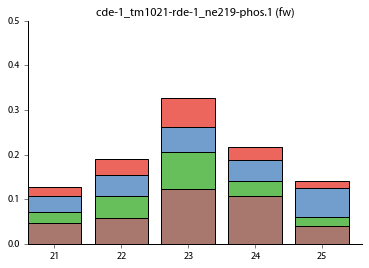

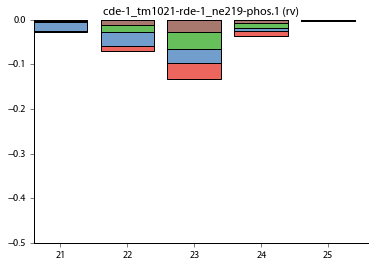

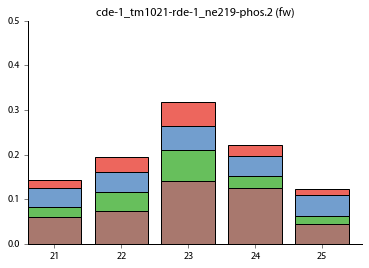

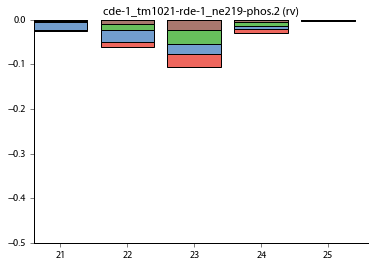

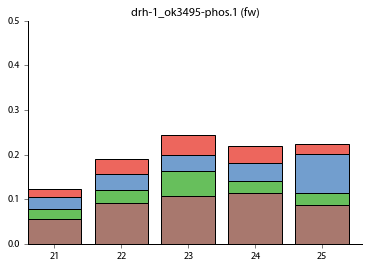

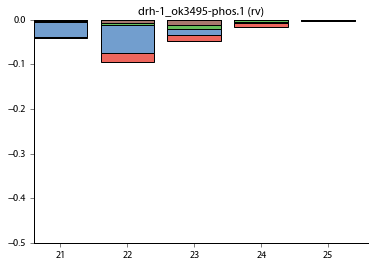

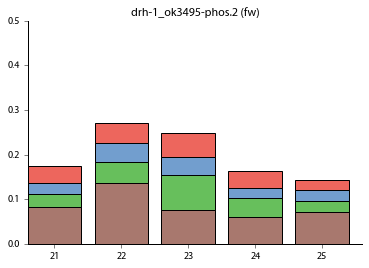

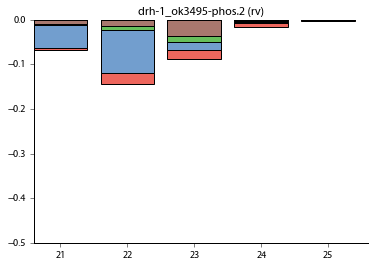

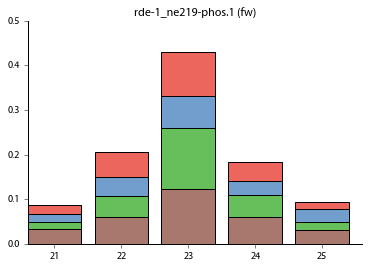

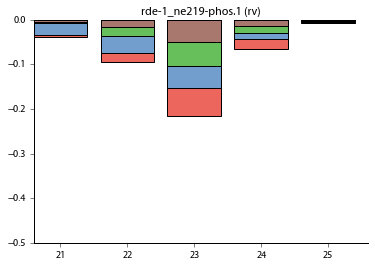

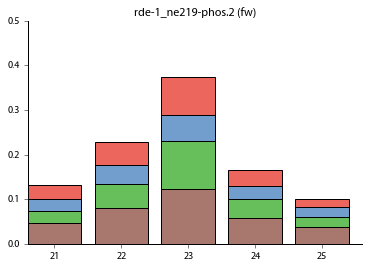

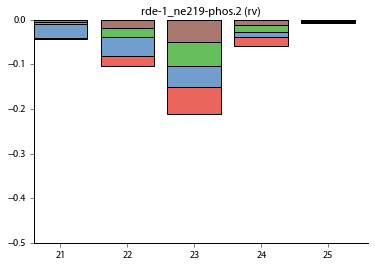

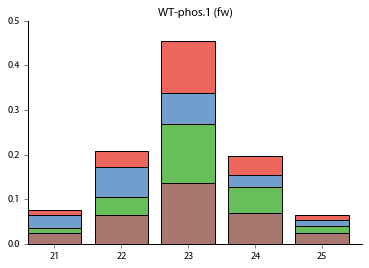

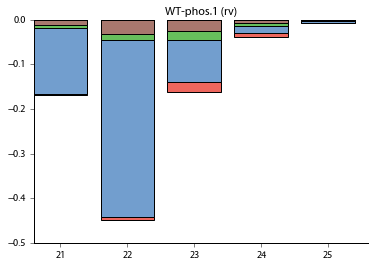

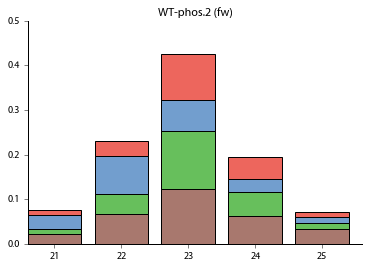

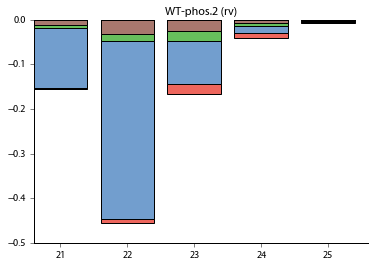

In [26]:
from tstk import peterplot as pp

for c in counts:
    title = "{}.{}".format(c["sid"],c["rep"])
    f = pp.plot(c["counts"],minlength=minlength,maxlength=maxlength,stranded=True,fwonly=True,ylims=(0,0.5),title=title + " (fw)",colours={"A":"#a8786e","C":"#67bf5c","G":"#729ece","T":"#ed665d"},isrna=True,legend=False)
    f.savefig("out/peterplot_viRNAs_{}.{}.fw.svg".format(c["sid"],c["rep"]))
    f = pp.plot(c["counts"],minlength=minlength,maxlength=maxlength,stranded=True,rvonly=True,ylims=(-0.5,0),title=title + " (rv)",colours={"A":"#a8786e","C":"#67bf5c","G":"#729ece","T":"#ed665d"},isrna=True,legend=False)
    f.savefig("out/peterplot_viRNAs_{}.{}.rv.svg".format(c["sid"],c["rep"]))

#### featurehist
See what's up with the 20nt fraction, which seems overrepresented in the mutants

TODO: modularize the featurecounts so there's no need to call through shell

## Viruses

In [15]:
%%px --local

#sids = ["test"]

vgenomes = {
    "orsay":{
        "RNA1": "ATGGCCAAACGTCTGAAACCGCATAATCAAACTCACGGCAAGAGTGGCGGACCCCCTAGTGCTCCCATTGGGAGCACTTAGGGCCAAAAATGCCCGGCTAGCCTCTCCAGCCGTCAACCTATGTGCCTAAACACATACCCAGGAGAGGTCCCACGGGACGGT",
        "RNA2": "CCAAAGTCGCTTGCTGTACACCACACATACCCGTCGCGGGGTTAGATCTCAGCCACTGTATGGCGTAAAATGACAGCGTTCCAAGGTTAGGGACGACAAGTGGGAATGGACGCTATCCATACCCGGCTATAACCTCTTTGGCCGT"
    }
}

In [16]:
@dview.parallel(block=False)
def get_tails_virus(params):
    '''
    For each sequence in the assembled RACE reads, check if the sequence starts with the viral genome.
    If it does, remove the viral genome and keep the tail. Empty tails are also kept (for full count -> normalisation).
    '''
    pid = params["pid"]
    sid = params["sid"]
    rep = params["rep"]
    vname = params["vname"]
    molecule = params["molecule"]
    if "fname" in params :
        fname = params["fname"]
    else:
        fname = "/nfs/users/nfs_t/tdd/lustre/projects/jeremie-race/out/{}-{}_{}.{}_pear_pear1_1.assembled.fastq".format(pid,molecule,sid,rep)
    vseq = vgenomes[vname][molecule]
    
    fpathnoext,fext,ftype,fh = openfastx(fname)
    reads = parsefastx(fh)
    
    tails = [r[1].replace(vseq,"") for r in reads if r[1].startswith(vseq)]
    nreads = len(tails)
    tails = [t for t in tails if t]

    return {"sid":sid,"rep":rep,"vname":vname,"molecule":molecule,"tails":tails,"nreads":nreads}

In [17]:
#This should be generalised to use all info in the "vgenomes" dict
sids = ["cde-1_mj414","cde-1_tm1021","drh-1","N2","rde-1"]
replicates = [1,2]
molecules = ["RNA1","RNA2"]
vtails_async = get_tails_virus.map([{"pid":"exp3","sid":sid,"rep":rep,"vname":"orsay","molecule":molecule} for sid in sids for rep in replicates for molecule in molecules])

In [22]:
if vtails_async.ready():
    vtails = vtails_async.get()
    with open("out/json/vgenome_tailing.json","w") as fo:
        fo.write(json.dumps(vtails))
    print("yeh")
else:
    print("no")
    

yeh


In [14]:
with open("out/json/vgenome_tailing.json") as f:
    vtails = json.load(f)

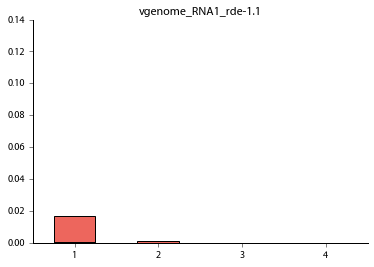

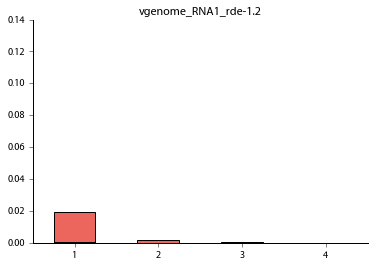

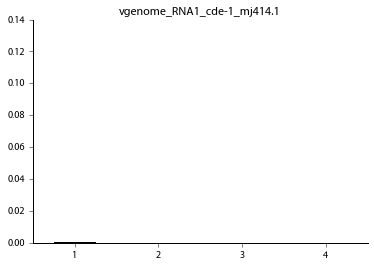

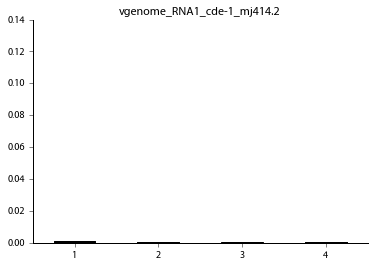

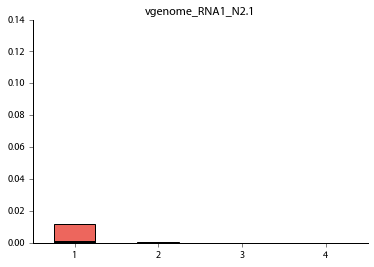

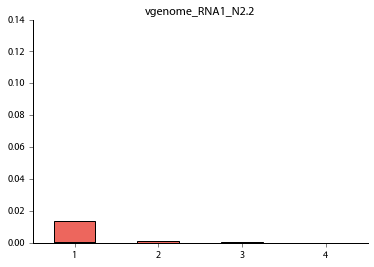

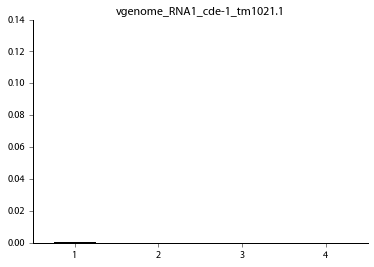

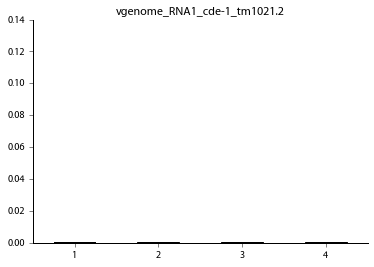

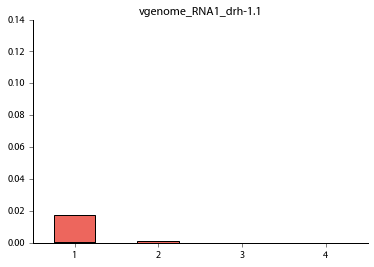

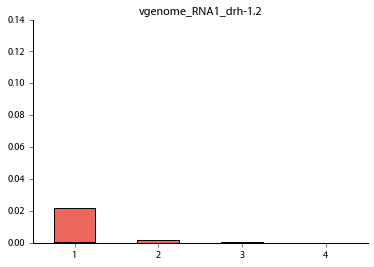

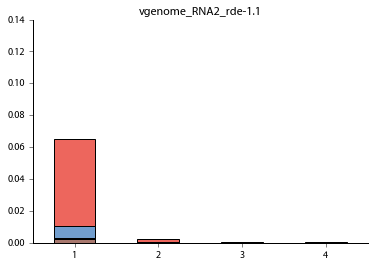

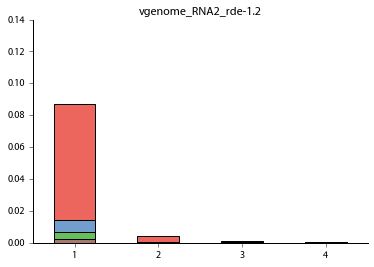

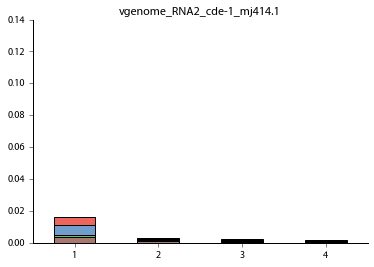

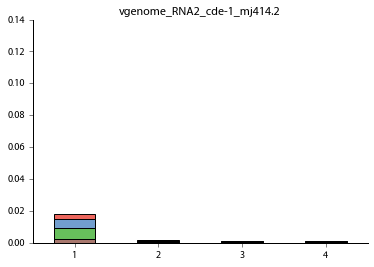

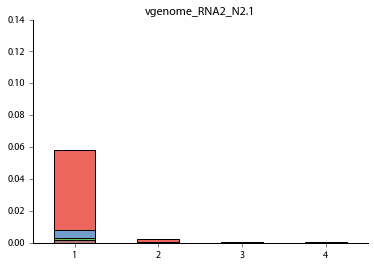

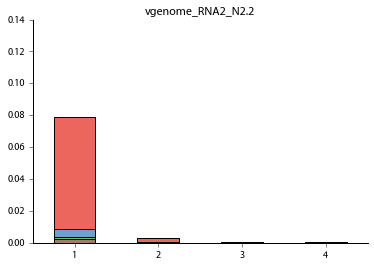

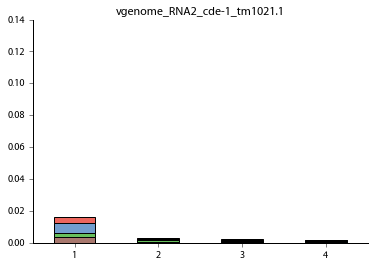

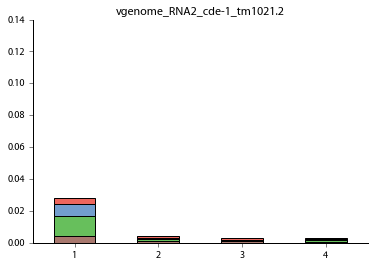

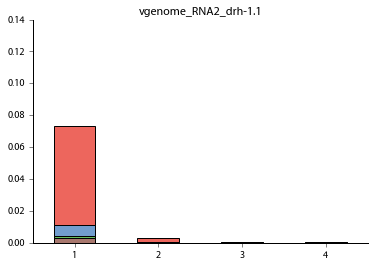

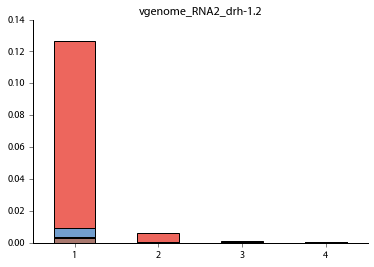

In [26]:
vgenome = {sid:{rid:{molecule:{"tails":[],"nreads":0} for molecule in molecules} for rid in replicates} for sid in sids}

for result in vtails:
    vgenome[result["sid"]][result["rep"]][result["molecule"]]["tails"] += result["tails"]
    vgenome[result["sid"]][result["rep"]][result["molecule"]]["nreads"] += result["nreads"]

for molecule in molecules:
    for sid in vgenome:
        for rep in replicates:
            title = "vgenome" + "_" + molecule + "_" + sid + "." + str(rep)
            plot_tails(vgenome[sid][rep][molecule]["tails"],vgenome[sid][rep][molecule]["nreads"], title, title,ylim=0.14,legend=False)

In [29]:
vgenome_u = {sid:{rid:{molecule:{"1":0,">1":0} for molecule in molecules} for rid in replicates} for sid in sids}

for result in vtails:
    molecule = result["molecule"]
    rep = result["rep"]
    sid = result["sid"]
    tails = result["tails"]
    nreads = result["nreads"]
    for tail in tails:
        if set(tail) == set('T'): #we're only counting tails made exclusively of Us
            if len(tail) == 1:
                vgenome_u[sid][rep][molecule]["1"] += 1
            else:
                vgenome_u[sid][rep][molecule][">1"] += 1
    vgenome_u[sid][rep][molecule]["1"] /= nreads
    vgenome_u[sid][rep][molecule][">1"] /= nreads

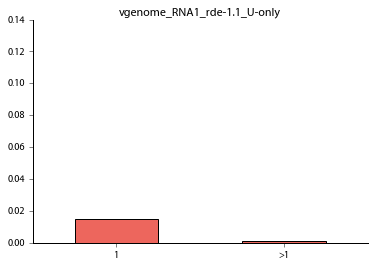

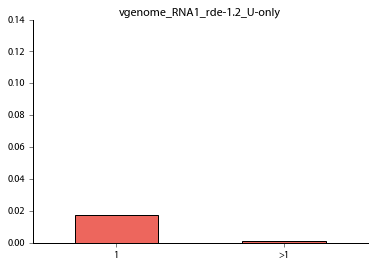

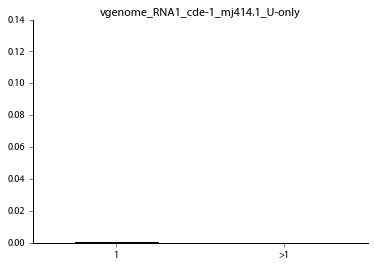

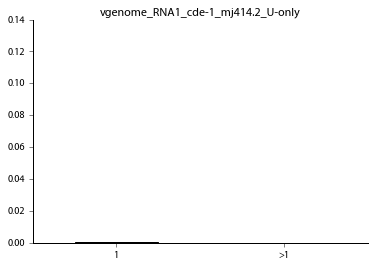

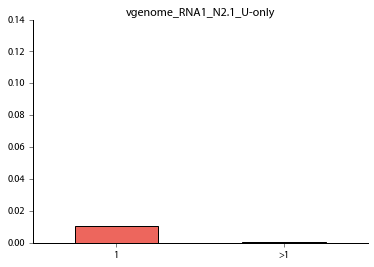

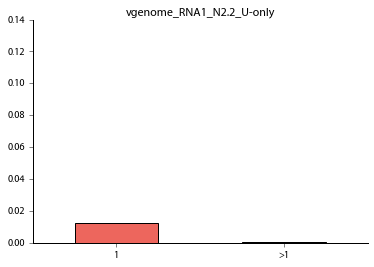

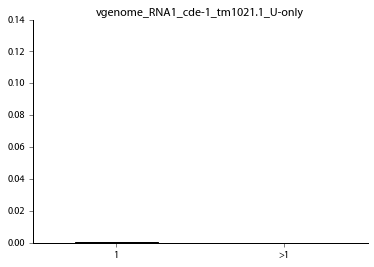

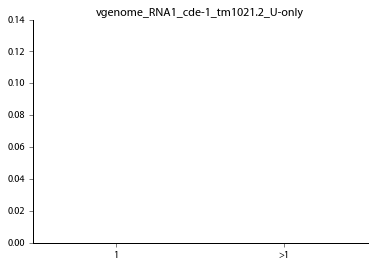

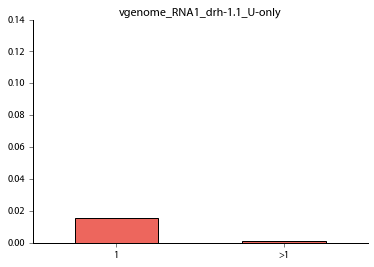

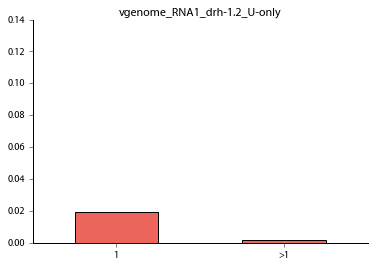

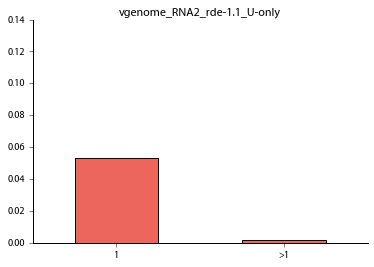

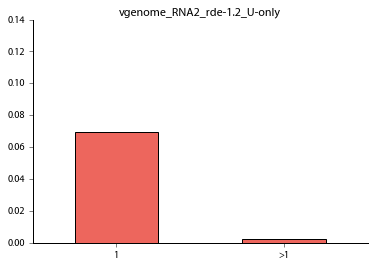

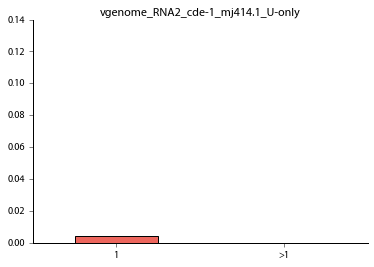

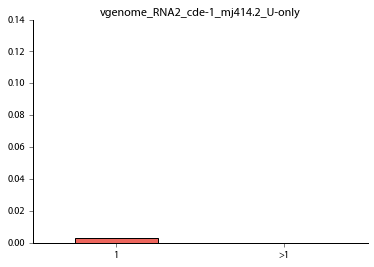

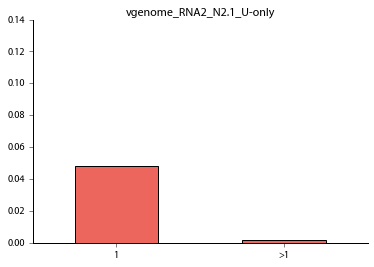

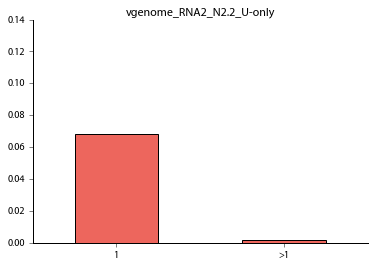

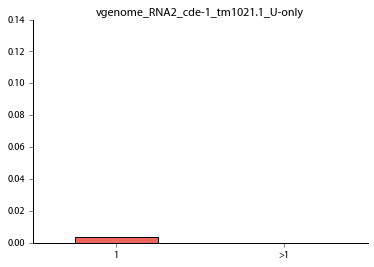

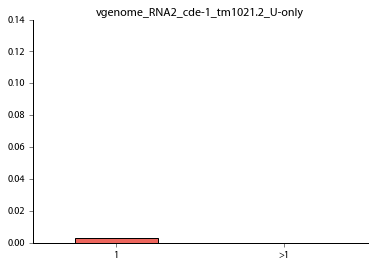

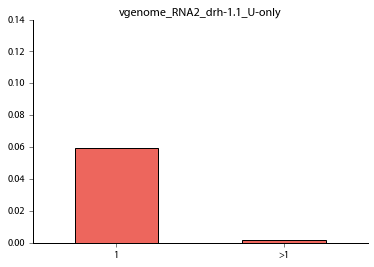

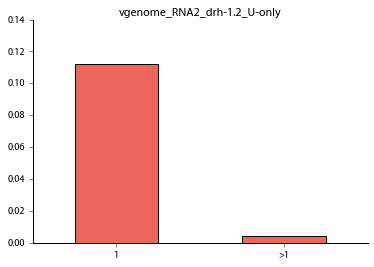

In [30]:
def plot_aggtails(s,ylim=0.14,title="Plot",save=True,ofname=None):
    ax = s.plot(kind='bar',rot=0,color=["#ed665d"])
    ax.set_ylim(0,ylim)
    ax.set_title("{}".format(title))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', direction='out')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if save :
        fig = ax.get_figure()
        fig.savefig('out/{}.svg'.format(ofname))

for molecule in molecules:
    for sid in vgenome_u:
        for rep in replicates:
            fig, ax = plt.subplots()
            title = "vgenome" + "_" + molecule + "_" + sid + "." + str(rep) + "_U-only"
            plot_aggtails(pd.Series(vgenome_u[sid][rep][molecule]),title=title,ofname=title)
            

# Counts

Provide a count (a number) for different classes of small RNAs (as done last year with old data). Only phos. Note: see counts.csv attachment in "ViRNA data" email thread, message from 2015-04-17. Also # of 1U in virus RNAs (and the total read count).


### vRNA types

In [20]:
sids = [
    "cde-1_mj414-phos",
    "cde-1_tm1021-drh-1_ok3495-phos",
    "cde-1_tm1021-phos",
    "cde-1_tm1021-rde-1_ne219-phos",
    "drh-1_ok3495-phos",
    "rde-1_ne219-phos",
    "WT-phos",
    "cde-1_mj414-nphos",
    "cde-1_tm1021-drh-1_ok3495-nphos",
    "cde-1_tm1021-nphos",
    "cde-1_tm1021-rde-1_ne219-nphos",
    "drh-1_ok3495-nphos",
    "rde-1_ne219-nphos",
    "WT-nphos"
]
replicates = ["1","2"]
cats = ["22G","dp23"]

with open("out/csv/counts_vrna_types.csv","w") as of:
    of.write(",".join(["sid","rep","cat","strand","nreads","libsize","normlibsize","nmirnas","normmirnas"]))
    of.write("\n")
    for cat in cats:
        for sid in sids:
            for rep in replicates:
                libsize = libsizes[sid][rep]
                nmirnas = wrnas["miRNAs"]["data"][sid][rep]['nreads']
                
                #destranded
                nreads = virnas[cat]["data"][sid][rep]["nreads"]["+"] + virnas[cat]["data"][sid][rep]["nreads"]["-"]
                normlibsize = nreads/libsize
                normmirnas = nreads/nmirnas
                of.write(",".join([str(s) for s in [sid,rep,cat,"both",nreads,libsize,normlibsize,nmirnas,normmirnas]]))
                of.write("\n")
                
                #stranded
                for strain in virnas[cat]["data"][sid][rep]["nreads"]:
                    nreads = virnas[cat]["data"][sid][rep]["nreads"][strain]
                    normlibsize = nreads/libsize
                    normmirnas = nreads/nmirnas
                    of.write(",".join([str(s) for s in [sid,rep,cat,strain,nreads,libsize,normlibsize,nmirnas,normmirnas]]))
                    of.write("\n")

In [122]:
#replaced by the new counting above, out of the virna data for the plots

#@dview.parallel(block=False)
#def counttypes(params):
#    sid=params["sid"]
#    rep=params["rep"]
#    chrname=params["chrname"]
#    
#    fpath = "{}/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam"
#    fpath = fpath.format(ROOTRMT)
#    
#    nreads = {l:{strand:{"A":0,"C":0,"T":0,"G":0} for strand in ["+","-"]} for l in [22,23]}
#    
#    bam = pysam.AlignmentFile(fpath)
#        
#    for r in bam.fetch(chrname):
#        if r.alen in [22,23] and goodcigar(r):
#            if r.is_reverse:
#                nreads[r.alen]["-"][compnt[r.seq[-1]]] += 1
#            else:
#                nreads[r.alen]["+"][r.seq[0]] += 1
#        
#    return {"sid":sid,"rep":rep,"chrname":chrname,"nreads":nreads}  


In [123]:
#sids = [
#    "cde-1_mj414-phos",
#    "cde-1_tm1021-drh-1_ok3495-phos",
#    "cde-1_tm1021-phos",
#    "cde-1_tm1021-rde-1_ne219-phos",
#    "drh-1_ok3495-phos",
#    "rde-1_ne219-phos",
#    "WT-phos",
#    "cde-1_mj414-nphos",
#    "cde-1_tm1021-drh-1_ok3495-nphos",
#    "cde-1_tm1021-nphos",
#    "cde-1_tm1021-rde-1_ne219-nphos",
#    "drh-1_ok3495-nphos",
#    "rde-1_ne219-nphos",
#    "WT-nphos"
#]
#replicates = ["1","2"]

#typecounts_remote = counttypes.map([{"sid":sid,"rep":rep,"chrname":chrname} for sid in sids for rep in replicates for chrname in chrnames_v])

In [127]:
#typecounts = {sid:{rep:{l:{strand:{"A":0,"C":0,"T":0,"G":0} for strand in ["+","-"]} for l in [22,23]} for rep in replicates} for sid in sids}
#for result in typecounts_remote.get():
#    sid = result["sid"]
#    rep = result["rep"]
#    for length in result["nreads"]:
#        for strand in result["nreads"][length]:
#            for nuc in result["nreads"][length][strand]:
#                typecounts[sid][rep][length][strand][nuc] += result["nreads"][length][strand][nuc]
#rows = []
                
#for sid in typecounts:
#    for rep in typecounts[sid]:
#        nmirnas = wrnas["miRNAs"]["data"][sid][rep]['nreads']
#        libsize = libsizes[sid][rep]
#        for length in typecounts[sid][rep]:
#            for strand in typecounts[sid][rep][length]:
#                for nuc in typecounts[sid][rep][length][strand]:
#                    nr = typecounts[sid][rep][length][strand][nuc]
#                    rows.append([sid,rep,length,strand,nuc,nr,nmirnas,nr/nmirnas,libsize,nr/libsize])
#df = pd.DataFrame(rows,columns=["strain","replicate","length","strand","5pnt","reads","miRNAs","reads/miRNAs","libsize","reads/libsize"])

#df = pd.pivot_table(df,index=['strain','replicate','length','strand'], columns='5pnt', values=['reads/miRNAs','reads/libsize'])

#df.to_csv("out/csv/counts_vrna_types.csv")

### vgenome tailing

In [22]:
sids = ["cde-1_mj414","cde-1_tm1021","drh-1","N2","rde-1"]
replicates = [1,2]
molecules = ["RNA1","RNA2"]

rows = []

#replaced this by grabbing the counts directing from the plot data
#for sid in sids:
#    for rep in replicates:
#        for molecule in molecules:
#            tails = vgenome[sid][rep][molecule]
#            nreads = len(tails)
#            n1us = sum(1 for t in tails if len(t) > 0 and t[0] == "T")
#            pct1us = n1us/nreads
#            rows.append([sid,rep,molecule,nreads,n1us,pct1us])
#df = pd.DataFrame(rows,columns=["strain","replicate","molecule","nreads","n1Us","pct1us"])
#df.to_csv("out/csv/counts_vgenome_tailing_1Us.csv",index=False)

for sid in sids:
    for rep in replicates:
        for molecule in molecules:
            data = vgenome_u[sid][rep][molecule]
            rows.append([sid,rep,molecule,data["1"],data[">1"]])
            
df = pd.DataFrame(rows,columns=["strain","replicate","molecule","pct1us","pct2plusus"])
df.to_csv("out/csv/counts_vgenome_tailing_Us.csv",index=False)

# miRNA analysis

In [9]:
fcountsout = "{}/out/featureCounts/featureCounts_WT-cde-1_tm1021-miRNAs.out".format(ROOTRMT)
deseqoutroot = "{}/out/deseq/deseq2_WT-cde-1_tm1021-miRNAs".format(ROOTRMT)

fcountsout_mirbase = "{}/out/featureCounts/featureCounts_WT-cde-1_tm1021-miRNAs_mirbase.out".format(ROOTRMT)
deseqoutroot_mirbase = "{}/out/deseq/deseq2_WT-cde-1_tm1021-miRNAs_mirbase".format(ROOTRMT)

count reads mapping to miRNAs

In [10]:
cmd = "{bin}/subread/1.5.0-p1/bin/featureCounts -T 12 -M --fraction -a {shrd}/annotations/c_elegans/Caenorhabditis_elegans.WBcel235.78.miRNA.gtf -o {fcountsout} {root}/out/exp2_{{WT,cde-1_tm1021}}-nphos.?_STAR_celegans.orsay.bam".format(bin=BINRMT,root=ROOTRMT,shrd=SHRDRMT,fcountsout=fcountsout)
counts_miRNA_async = runcmd(cmd)
counts_miRNA_async.get()

/nfs/users/nfs_t/tdd/nfs/software/subread/1.5.0-p1/bin/featureCounts -T 12 -M --fraction -a /lustre/scratch108/compgen/team224/tdd/shared/res/annotations/c_elegans/Caenorhabditis_elegans.WBcel235.78.miRNA.gtf -o /lustre/scratch108/compgen/team224/tdd/projects/jeremie/out/featureCounts/featureCounts_WT-cde-1_tm1021-miRNAs.out /lustre/scratch108/compgen/team224/tdd/projects/jeremie/out/exp2_{WT,cde-1_tm1021}-nphos.?_STAR_celegans.orsay.bam


In [117]:
cmd_mirbase = "{bin}/subread/1.5.0-p1/bin/featureCounts -T 12 -t miRNA_primary_transcript -g Name -M --fraction -a {shrd}/annotations/c_elegans/miRBase21_hairpins_WBcel235.gff3 -o {fcountsout} {root}/out/exp2_{{WT,cde-1_tm1021}}-nphos.?_STAR_celegans.orsay.bam".format(bin=BINRMT,root=ROOTRMT,shrd=SHRDRMT,fcountsout=fcountsout_mirbase)
counts_miRNA_mirbase_async = runcmd(cmd_mirbase)
counts_miRNA_mirbase_async.get()

['',
 '        ==========     _____ _    _ ____  _____  ______          _____  ',
 '        =====         / ____| |  | |  _ \\|  __ \\|  ____|   /\\   |  __ \\ ',
 '          =====      | (___ | |  | | |_) | |__) | |__     /  \\  | |  | |',
 '            ====      \\___ \\| |  | |  _ <|  _  /|  __|   / /\\ \\ | |  | |',
 '              ====    ____) | |__| | |_) | | \\ \\| |____ / ____ \\| |__| |',
 '        ==========   |_____/ \\____/|____/|_|  \\_\\______/_/    \\_\\_____/',
 '\tv1.5.0-p1',
 '',
 '//========================== featureCounts setting ===========================\\\\',
 '||                                                                            ||',
 '||             Input files : 4 BAM files                                      ||',
 '||                           S /lustre/scratch108/compgen/team224/tdd/pro ... ||',
 '||                           S /lustre/scratch108/compgen/team224/tdd/pro ... ||',
 '||                           S /lustre/scratch108/compgen/team224/t

run deseq on the counts

In [118]:
diff_miRNA_async = {}

cmd = "Rscript {bin}/deseqstuff/deseq2.R {fcountsout} WT 6 7 cde-1 8 9 {deseqoutroot}".format(bin=BINRMT,fcountsout=fcountsout,deseqoutroot=deseqoutroot)
diff_miRNA_async = runcmd(cmd)

In [119]:
diff_miRNA_async.get()

['[1] WT    WT    cde-1 cde-1',
 'Levels: cde-1 WT',
 'Loading required package: S4Vectors',
 'Loading required package: methods',
 'Loading required package: stats4',
 'Loading required package: BiocGenerics',
 'Loading required package: parallel',
 '',
 'Attaching package: ‘BiocGenerics’',
 '',
 'The following objects are masked from ‘package:parallel’:',
 '',
 '    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,',
 '    clusterExport, clusterMap, parApply, parCapply, parLapply,',
 '    parLapplyLB, parRapply, parSapply, parSapplyLB',
 '',
 'The following object is masked from ‘package:stats’:',
 '',
 '    xtabs',
 '',
 'The following objects are masked from ‘package:base’:',
 '',
 '    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,',
 '    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,',
 '    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,',
 '    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,',
 '  

In [120]:
diff_miRNA_mirbase_async = {}

cmd_mirbase = "Rscript {bin}/deseqstuff/deseq2.R {fcountsout} WT 6 7 cde-1 8 9 {deseqoutroot}".format(bin=BINRMT,fcountsout=fcountsout_mirbase,deseqoutroot=deseqoutroot_mirbase)
diff_miRNA_mirbase_async = runcmd(cmd_mirbase)

In [121]:
diff_miRNA_mirbase_async.get()

['[1] WT    WT    cde-1 cde-1',
 'Levels: cde-1 WT',
 'Loading required package: S4Vectors',
 'Loading required package: methods',
 'Loading required package: stats4',
 'Loading required package: BiocGenerics',
 'Loading required package: parallel',
 '',
 'Attaching package: ‘BiocGenerics’',
 '',
 'The following objects are masked from ‘package:parallel’:',
 '',
 '    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,',
 '    clusterExport, clusterMap, parApply, parCapply, parLapply,',
 '    parLapplyLB, parRapply, parSapply, parSapplyLB',
 '',
 'The following object is masked from ‘package:stats’:',
 '',
 '    xtabs',
 '',
 'The following objects are masked from ‘package:base’:',
 '',
 '    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,',
 '    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,',
 '    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,',
 '    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,',
 '  

In [45]:
def maplot(data,pthres=0.05,l2fcthres=1,pcol="padj",title="MA plot",bmcol="baseMean",l2fccol="log2FoldChange"):
    fig, ax = plt.subplots(figsize=(14,12))
    data_sig_fc = data[(data[pcol] < pthres) & (abs(data[l2fccol]) >= l2fcthres)]
    data_sig = data[(data[pcol] < pthres) & (abs(data[l2fccol]) < l2fcthres)]
    data_nsig = data[(data[pcol] >= pthres) | pd.isnull(data[pcol])]

    ax.plot(data_nsig[bmcol], data_nsig[l2fccol], marker='.', linestyle='', ms=10, label="padj > {}".format(pthres),c=colours["l1"])
    ax.plot(data_sig[bmcol], data_sig[l2fccol], marker='.', linestyle='', ms=10, label="padj < {} & l2fc < {}".format(pthres,l2fcthres),c=colours["l2"])
    ax.plot(data_sig_fc[bmcol], data_sig_fc[l2fccol], marker='.', linestyle='', ms=10, label="padj < {} & l2fc >= {}".format(pthres,l2fcthres),c=colours["l3"])
    ax.set_xscale("log")
    ax.set_xlabel(bmcol)
    ax.set_ylabel(l2fccol)
    ax.set_title(title)
    ax.legend()
    fig.savefig("out/maplot-{}.svg".format(title))
    
def vplot(data,pthres=0.05,l2fcthres=1,pcol="padj",title="Volcano plot",bmcol="baseMean",l2fccol="log2FoldChange"):
    fig, ax = plt.subplots(figsize=(14,12))
    data_sig_fc = data[(data[pcol] < pthres) & (abs(data[l2fccol]) >= l2fcthres)]
    data_sig = data[(data[pcol] < pthres) & (abs(data[l2fccol]) < l2fcthres)]
    data_nsig = data[(data[pcol] >= pthres) | pd.isnull(data[pcol])]

    ax.plot(data_nsig[l2fccol], data_nsig[pcol], marker='.', linestyle='', ms=10, label="padj > {}".format(pthres),c=colours["l1"])
    ax.plot(data_sig[l2fccol], data_sig[pcol], marker='.', linestyle='', ms=10, label="padj < {} & l2fc < {}".format(pthres,l2fcthres),c=colours["l2"])
    ax.plot(data_sig_fc[l2fccol], data_sig_fc[pcol], marker='.', linestyle='', ms=10, label="padj < {} & l2fc >= {}".format(pthres,l2fcthres),c=colours["l3"])
    ax.set_yscale("log",basey=10)
    ax.set_xlabel(l2fccol)
    ax.set_ylabel(pcol)
    ax.set_title(title)
    ax.legend()
    plt.ylim(plt.ylim()[1],plt.ylim()[0])
    fig.savefig("out/vplot-{}.svg".format(title))

In [48]:
colours = {
    "l1": "#999999",
    "l2":"#E69F00",
    "l3":"#D55E00" 
}

@dview.parallel(block=False)
def getdata_deseq(fname):
    tmpdf = pd.read_table(fname,sep=",")
    tmpdf = tmpdf.drop(tmpdf.columns[0],1)
    tmpdf = tmpdf.set_index("Gene")
    #tmpdf = pd.DataFrame(tmpdf[[tmpdf.columns[1],"padj","baseMean"]])
    strain = fname#.split("_")[-1].rstrip(".out")
    #tmpdf.columns = ["l2fc","padj","baseMean"]
    return (strain,tmpdf)

@dview.parallel(block=False)
def getdata_deseq_vs(fname):
    tmpdf = pd.read_table(fname,sep=",")
    strain = fname#.split("_")[-1].rstrip(".out")
    return (strain,tmpdf)

miRNA_async = getdata_deseq.map(rglob(deseqoutroot + ".out"))
miRNA_diffexp = miRNA_async.get()[0][1]
miRNA_diffexp.columns = list(miRNA_diffexp.columns[0:-4]) + ["WT.1","WT.2","cde-1.1","cde-1.2"]

miRNA_mirbase_async = getdata_deseq.map(rglob(deseqoutroot_mirbase + ".out"))
miRNA_diffexp_mirbase = miRNA_mirbase_async.get()[0][1]
miRNA_diffexp_mirbase.columns = list(miRNA_diffexp_mirbase.columns[0:-4]) + ["WT.1","WT.2","cde-1.1","cde-1.2"]

In [49]:
miRNA_diffexp

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,WT.1,WT.2,cde-1.1,cde-1.2
Gene,,,,,,,,,,
WBGene00003333,2254.280739,-1.957240,0.221129,-8.851130,8.663747e-19,1.160942e-16,679.000141,1063.705746,3959.795510,3314.621559
WBGene00003284,1553.476667,-1.591572,0.187880,-8.471216,2.428439e-17,1.627054e-15,798.213906,704.509842,2218.755160,2492.427761
WBGene00003330,19966.679071,1.367132,0.174388,7.839578,4.520629e-15,2.019214e-13,27123.723180,30901.259259,11677.825797,10163.908048
WBGene00003328,27651.355499,1.273609,0.177204,7.187244,6.611209e-13,2.214755e-11,42421.440856,36467.928155,17107.268859,14608.784125
WBGene00003261,2694.329846,-1.182392,0.179914,-6.571988,4.964774e-11,1.330560e-09,1733.264481,1501.855340,3623.331924,3918.867639
WBGene00003283,4011.501141,-1.079519,0.171926,-6.278958,3.408493e-10,7.612301e-09,2650.692153,2425.006167,5353.262628,5617.043616
WBGene00003334,1598.646179,1.208646,0.211710,5.708970,1.136622e-08,2.175820e-07,2092.979060,2418.932806,1109.377580,773.295272
WBGene00003324,238.853678,-1.462823,0.258691,-5.654706,1.561133e-08,2.614897e-07,131.653462,109.320493,342.811956,371.628803
WBGene00003335,669.183319,1.124078,0.208158,5.400105,6.660184e-08,9.916273e-07,940.233783,912.739351,450.734238,373.025904


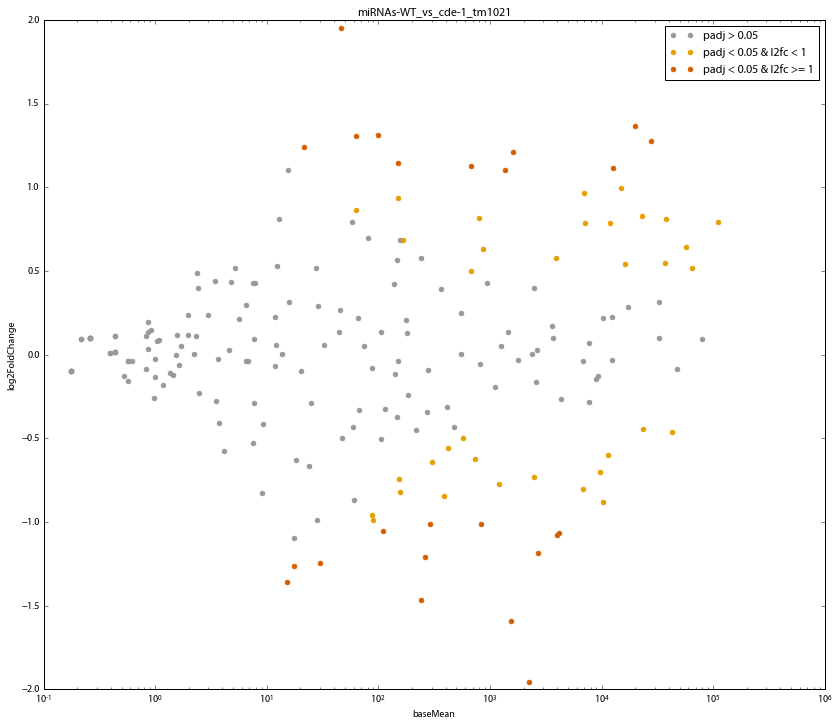

In [50]:
maplot(miRNA_diffexp,title="miRNAs-WT_vs_cde-1_tm1021")

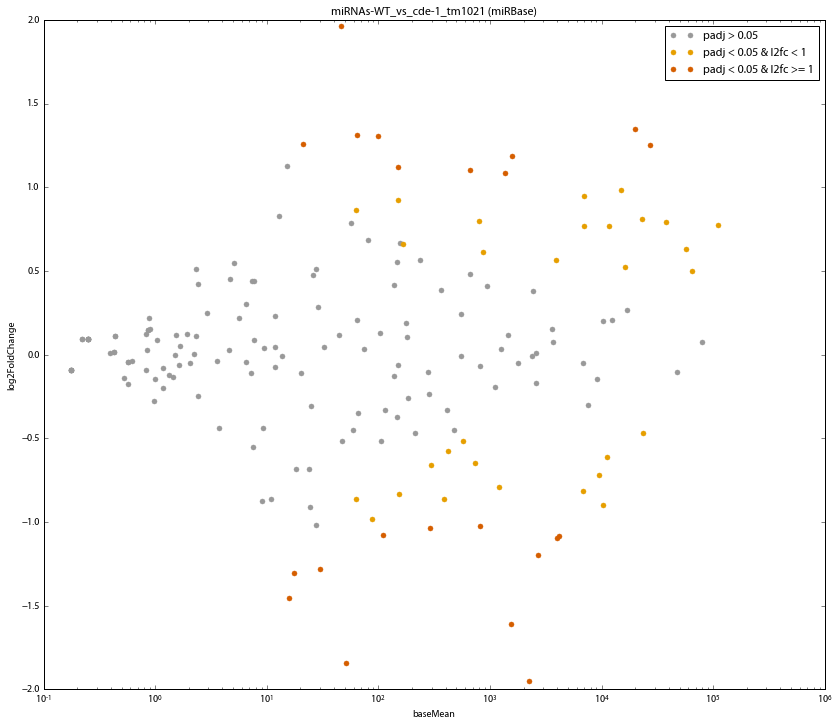

In [137]:
maplot(miRNA_diffexp_mirbase,title="miRNAs-WT_vs_cde-1_tm1021_miRBase")

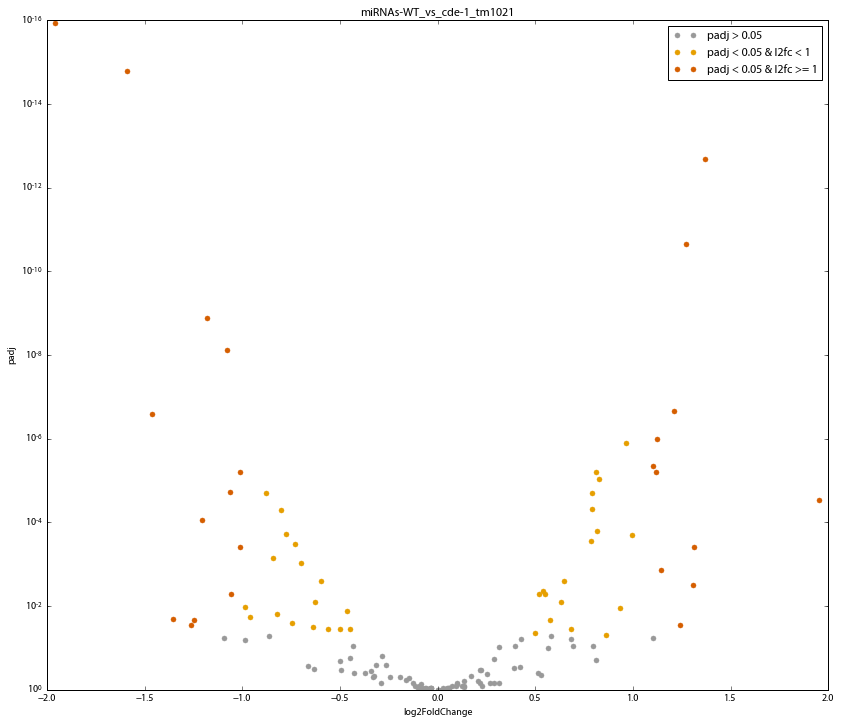

In [84]:
vplot(miRNA_diffexp,title="miRNAs-WT_vs_cde-1_tm1021")

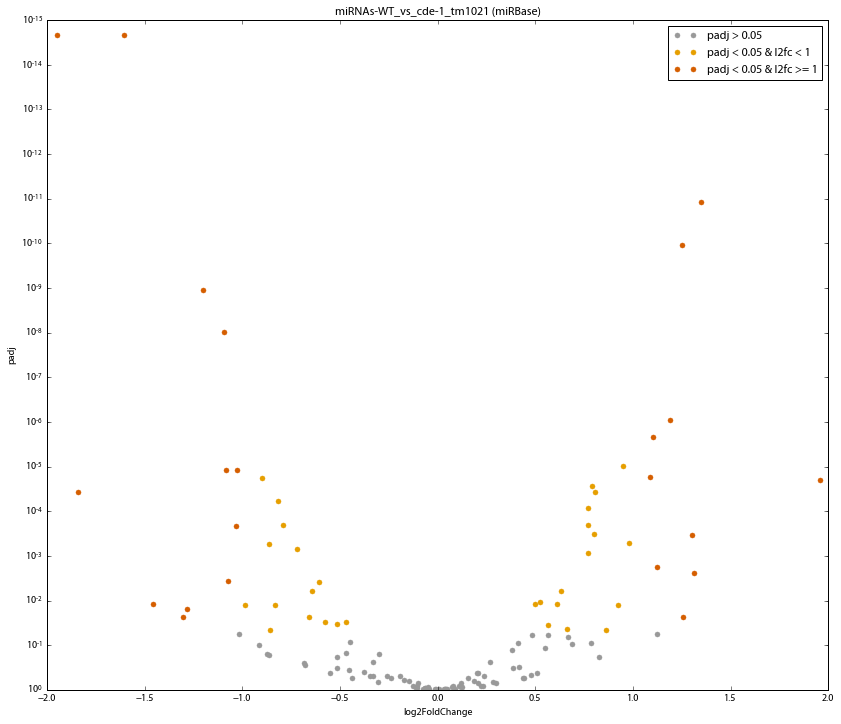

In [139]:
vplot(miRNA_diffexp_mirbase,title="miRNAs-WT_vs_cde-1_tm1021_miRBase")

In [51]:
from scipy.stats.stats import pearsonr

vsdata = getdata_deseq_vs.map(rglob("{}/out/deseq/deseq2_WT-cde-1_tm1021-miRNAs-vsd.out".format(ROOTRMT)))
vsdata = vsdata.get()[0][1]
vsdata.columns = ["Geneid","WT.1","WT.2","cde-1.1","cde-1.2"]

vsdata_mirbase = getdata_deseq_vs.map(rglob("{}/out/deseq/deseq2_WT-cde-1_tm1021-miRNAs_mirbase-vsd.out".format(ROOTRMT)))
vsdata_mirbase = vsdata_mirbase.get()[0][1]
vsdata_mirbase.columns = ["Geneid","WT.1","WT.2","cde-1.1","cde-1.2"]

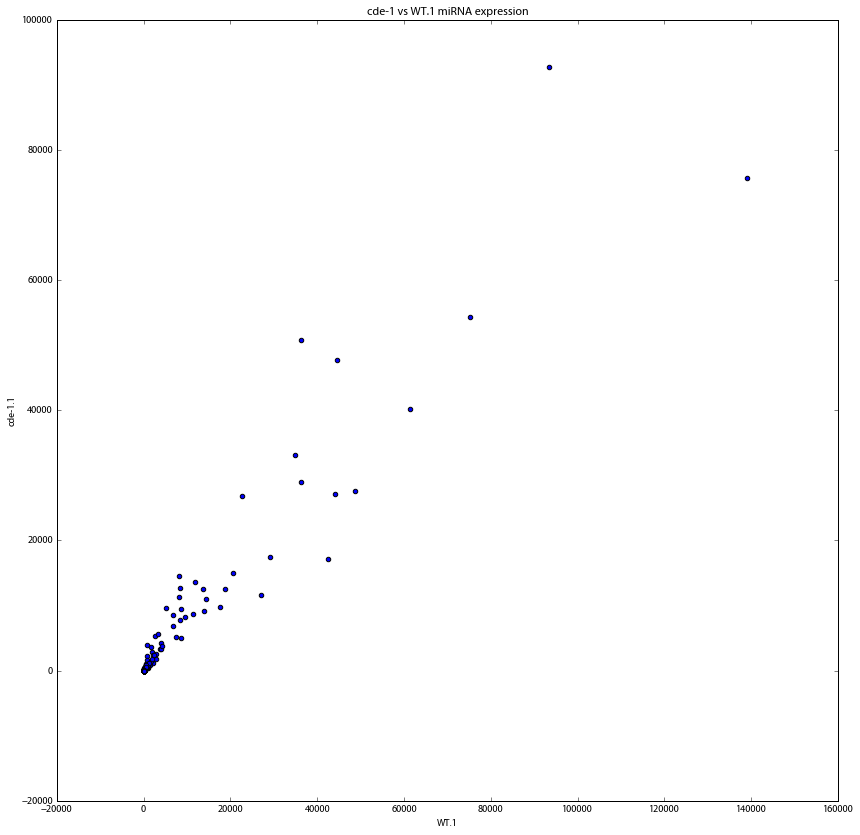

In [52]:
ax = miRNA_diffexp.plot(kind="scatter",x="WT.1",y="cde-1.1",figsize=(14,14), title="cde-1 vs WT.1 miRNA expression")

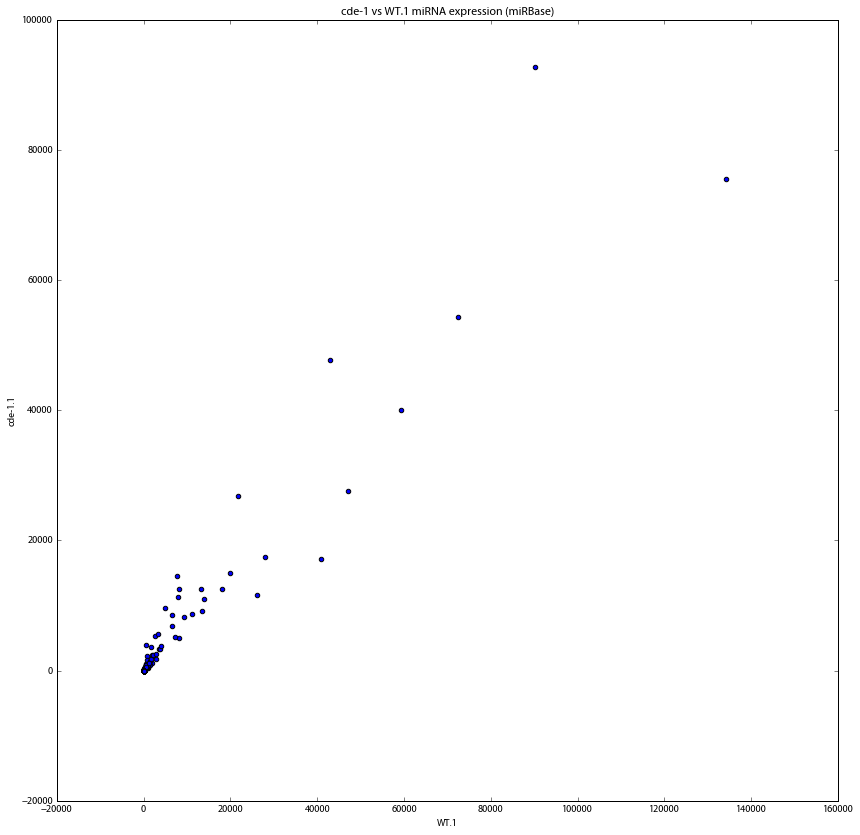

In [142]:
ax = miRNA_diffexp_mirbase.plot(kind="scatter",x="WT.1",y="cde-1.1",figsize=(14,14), title="cde-1 vs WT.1 miRNA expression (miRBase)")

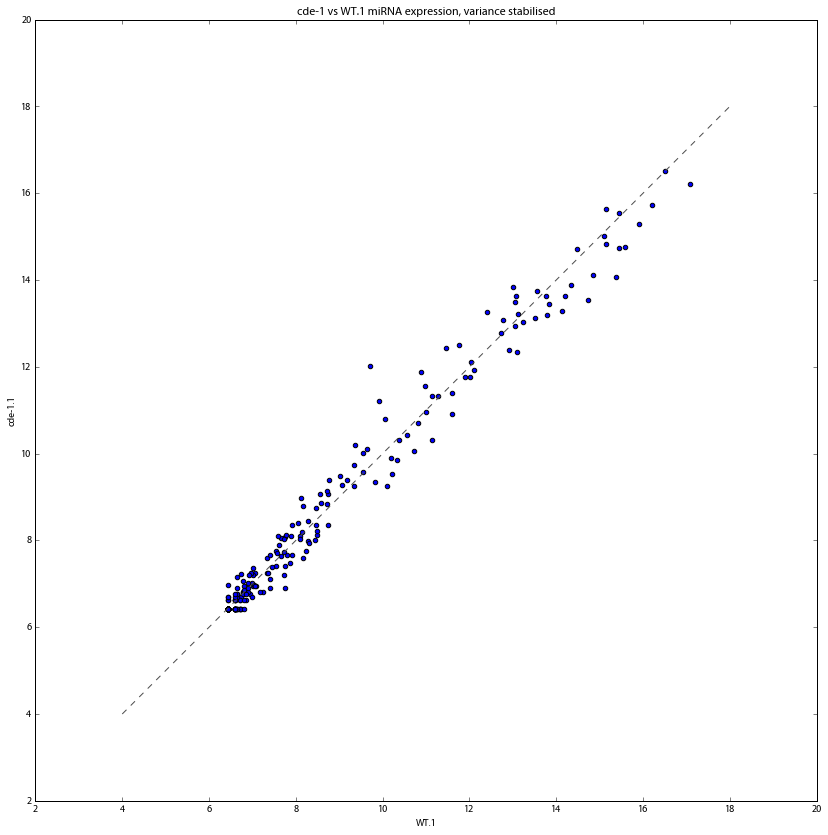

In [110]:
ax = vsdata.plot(kind="scatter",x="WT.1",y="cde-1.1",figsize=(14,14), title="cde-1 vs WT.1 miRNA expression, variance stabilised")
ax.plot(ax.get_xlim(),ax.get_ylim(), ls="--", c=".3")

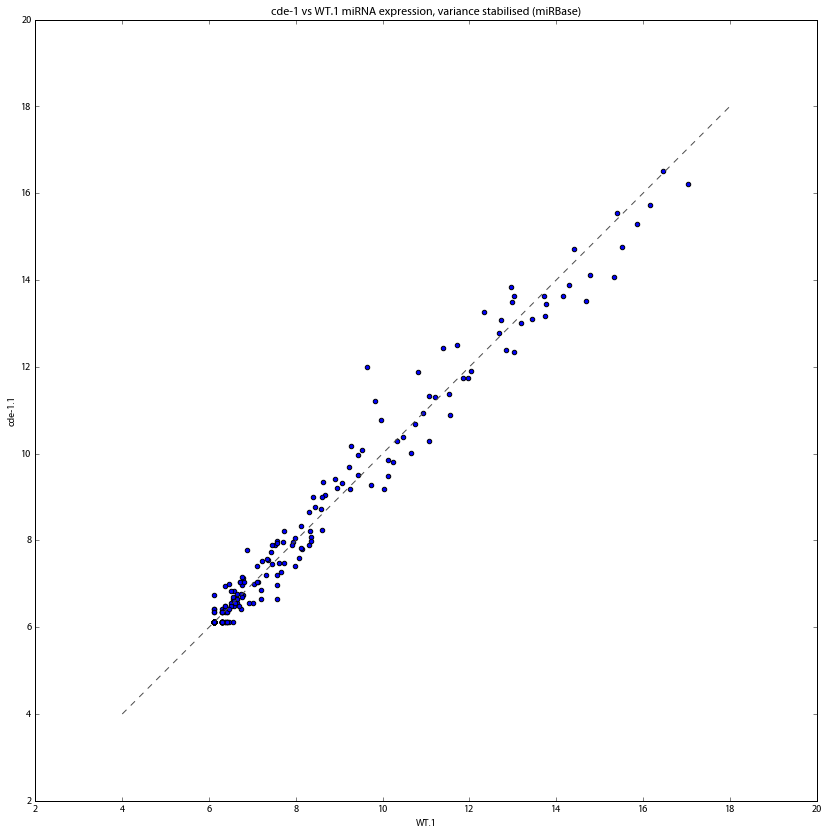

In [53]:
ax = vsdata_mirbase.plot(kind="scatter",x="WT.1",y="cde-1.1",figsize=(14,14), title="cde-1 vs WT.1 miRNA expression, variance stabilised (miRBase)")
ax.plot(ax.get_xlim(),ax.get_ylim(), ls="--", c=".3")
fig = ax.get_figure()
fig.savefig("")

## Correlation

In [54]:
from itertools import combinations_with_replacement

corrs = []

for c in combinations_with_replacement(list(vsdata.columns)[1:],2):
    corrs.append([c[0],c[1],pearsonr(vsdata[c[0]],vsdata[c[1]])[0]])
corrsdf = pd.DataFrame(corrs,columns=["sample1","sample2","corr"]).pivot(index="sample1",columns="sample2",values="corr")
corrsdf.to_csv("out/csv/correlation_table_miRNA.csv")

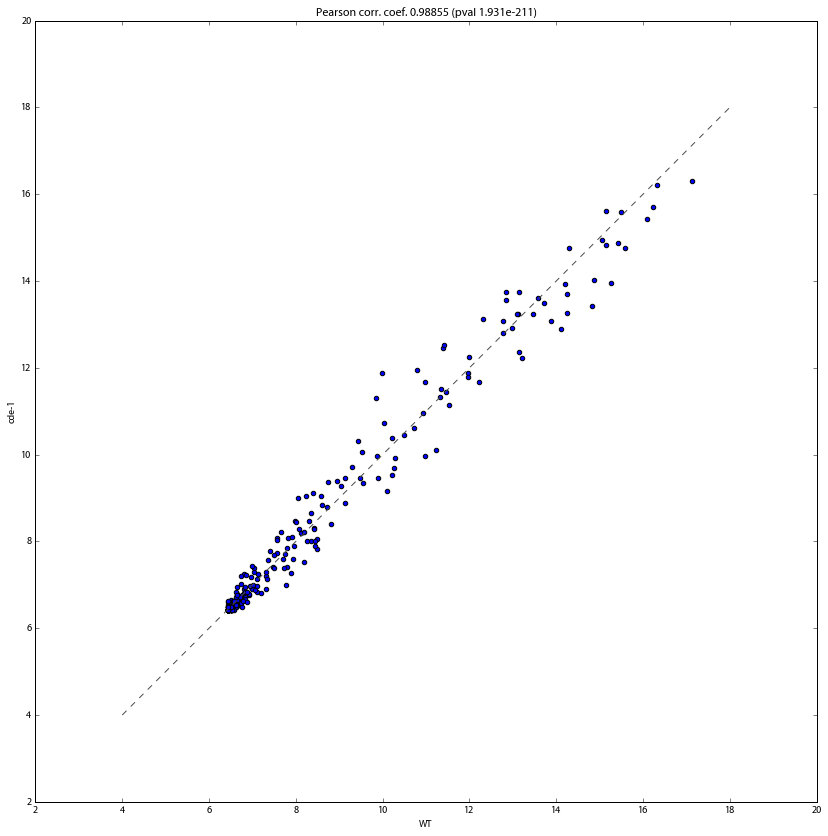

In [55]:
vsdata["WT"] = (vsdata["WT.1"] + vsdata["WT.2"]) / 2
vsdata["cde-1"] = (vsdata["cde-1.1"] + vsdata["cde-1.2"]) / 2

coef,pval = pearsonr(vsdata["WT"],vsdata["cde-1"])
ax = vsdata.plot(kind="scatter",x="WT",y="cde-1",figsize=(14,14),title="Pearson corr. coef. {} (pval {:.3e})".format(round(coef,5),pval))
ax.plot(ax.get_xlim(),ax.get_ylim(), ls="--", c=".3")
fig = ax.get_figure()
fig.savefig("out/corrplot_miRNAs-WT_vs_cde-1_tm1021.svg")

----

----

# TESTS

## sRNA tailing

In [11]:
%%px --target 1

header = { 
    'HD': {'VN': '1.0'},
    'SQ': [
        {'LN': 1000, 'SN': 'chr1'},
        {'LN': 2000, 'SN': 'chr2'}
    ]
}

G22fw = "GAAAAAAAAAAAAAAAAAAAAA"
G22rv = "AAAAAAAAAAAAAAAAAAAAAC"

M = 0
S = 4

outfile = pysam.AlignmentFile("{}/test/sRNA.sam".format(ROOTRMT), "wh", header=header)

seq = "AGCTTAGCTAGCTACCTATATCTTGGTCTTGGCCG"
a = pysam.AlignedSegment()
a.query_name = "read_28833_29006_6945"
a.query_sequence=seq
a.flag = 0
a.reference_id = 0
a.reference_start = 32
a.mapping_quality = 20
a.cigar = ((M,22), (S,1))
a.next_reference_id = 0
a.next_reference_start=199
a.template_length=167
a.query_qualities = [40 for c in seq]
for t in [('NH', 1), ('HI', 1), ('AS', 25), ('nM', 0)]:
    a.set_tag(t[0],t[1])

outfile.write(a)
outfile.close()

## vtailing

In [12]:
%%px --target 1

tails = []

maxlength = 6
for n in ["A","C","T","G"]:
    for i in range(0,maxlength):
        tails += [n * (maxlength - i)] * (i+1)

tails += [""] * (100 - len(tails))

from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_dna

records = []

for i,t in enumerate(tails):
    record = SeqRecord(Seq("ATGGCCAAACGTCTGAAACCGCATAATCAAACTCACGGCAAGAGTGGCGGACCCCCTAGTGCTCCCATTGGGAGCACTTAGGGCCAAAAATGCCCGGCTAGCCTCTCCAGCCGTCAACCTATGTGCCTAAACACATACCCAGGAGAGGTCCCACGGGACGGT"+t,
                       generic_dna),
                       id="s{}".format(i), name="seq{}".format(i),
                       description="simulated orsay RNA1 molecule")
    record.letter_annotations["phred_quality"] = [40 for n in record.seq]
    records.append(record)

with open("{}/test/vtailing_RNA1.fastq".format(ROOTRMT), "w") as fo:
    SeqIO.write(records, fo, "fastq")

In [22]:
molecules = ["RNA1"]
vtails_test = get_tails_virus.map([{"pid":"pid","sid":"sid","rep":"rep","vname":"orsay","molecule":molecule,"fname":"{}/test/vtailing_{}.fastq".format(ROOTRMT,molecule)} for molecule in molecules])

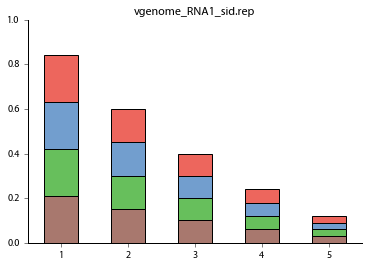

In [23]:
sids=["sid"]
replicates=["rep"]
vgenome = {sid:{rid:{molecule:[] for molecule in molecules} for rid in replicates} for sid in sids}

for result in vtails_test:
    vgenome[result["sid"]][result["rep"]][result["molecule"]] += result["tails"]

for molecule in molecules:
    for sid in vgenome:
        for rep in replicates:
            title = "vgenome" + "_" + molecule + "_" + sid + "." + str(rep)
            plot_tails(vgenome[sid][rep][molecule],len(vgenome[sid][rep][molecule]), title, title,ylim=1,legend=False,save=False)

## wtailing

In [34]:
test = {
    "srna":{"async":{"done":False,"res":None},"data":{}},
    "dp":{"async":{"done":False,"res":None},"data":{}},
    "miRNAs":{"async":{"done":False,"res":None},"data":{}},
    "siRNAs":{"async":{"done":False,"res":None},"data":{}}
}
#test["srna"]["async"]["res"] = get_tails_srna.map([{"sid":"test","rep":"1","fname":"/test/alignment/Aligned.sortedByCoord.out.bam","chrname":chrname,"nt5p":"G","lengths":[22]} for chrname in ["chrI","chrII"]])
#test["dp"]["async"]["res"] = get_tails_dp.map([{"sid":"test","rep":"1","fname":"{}/test/alignment/Aligned.sortedByCoord.out.bam".format(ROOTRMT),"chrname":chrname,"offset":2,"lengths":[23]} for chrname in ["chrI","chrII"]])
#test["miRNAs"]["async"]["res"] = get_tails_list.map([{"sid":"test","rep":"1","fname_filters":"{}/test/alignment/Aligned.sortedByCoord.out.bam".format(ROOTRMT),"chrname":chrname,"fname_targets": SHRDRMT + "/sequences/c_elegans/miRBase21_hairpins.fasta"} for chrname in ["chrI","chrII"]])
test["siRNAs"]["async"]["res"] = get_tails_sirna.map([{"sid":"test","rep":"1","annfile":"{}/test/genome.gtf".format(ROOTRMT),"fname":"{}/test/alignment/Aligned.sortedByCoord.out.bam".format(ROOTRMT),"chrname":chrname,"nt5p":"G","lengths":[22]} for chrname in ["chrI","chrII"]])

In [30]:
test["siRNAs"]["async"]["res"].get()

[{'chrname': 'chrI',
  'ids': ['07.chrI-22Grvsplitted', '02.chrI-22Grv', '05.chrI-22Grv'],
  'nreads': 3,
  'rep': '1',
  'sid': 'test',
  'tails': []},
 {'chrname': 'chrII',
  'ids': ['09.chrII-22Grv'],
  'nreads': 1,
  'rep': '1',
  'sid': 'test',
  'tails': []}]

{'siRNAs': {'data': {'test': {'1': {'tails': ['TG', 'GGG'], 'nreads': 4}}}, 'async': {'res': <AsyncMapResult: finished>, 'done': True}}, 'srna': {'data': {}, 'async': {'res': None, 'done': False}}, 'dp': {'data': {}, 'async': {'res': None, 'done': False}}, 'miRNAs': {'data': {}, 'async': {'res': None, 'done': False}}}


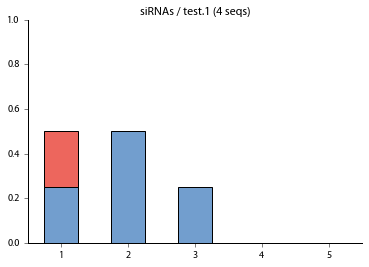

In [35]:
test_results = reshape_remote(test)
print(test_results)
plot_results(test_results,"siRNAs",prefix="mirna_",ylim=1,save=False)
#plot_results(test_results,"miRNAs",prefix="mirna_",ylim=1,save=False)
#plot_results(test_results,"srna",prefix="srna_",ylim=1,save=False)
#plot_results(test_results,"dp",prefix="dp_",ylim=1,save=False)

In [76]:
@dview.parallel(block=False)
def get_counts_range(params):
    sid=params["sid"]
    rep=params["rep"]
    chrname=params["chrname"]
    fname=params["fname"]
    
    bam = pysam.AlignmentFile(fname)
    counts = {n:0 for n in range(0,3000)}
    for aln in bam.fetch(chrname,0,3000):
        counts[aln.reference_start] += 1
        
    return {"sid":sid,"rep":rep,"chrname":chrname,"counts":counts}

sids = [
    "cde-1_tm1021-phos",
    "cde-1_tm1021-nphos"
]
replicates = ["1","2"]

res_async = get_counts_range.map([{"sid":sid,"rep":rep,"fname":ROOTRMT + "/out/exp2_"+sid+"."+rep+"_STAR_celegans.orsay.bam","chrname":"RNA2"} for sid in sids for rep in replicates])


In [77]:
data = res_async.get()

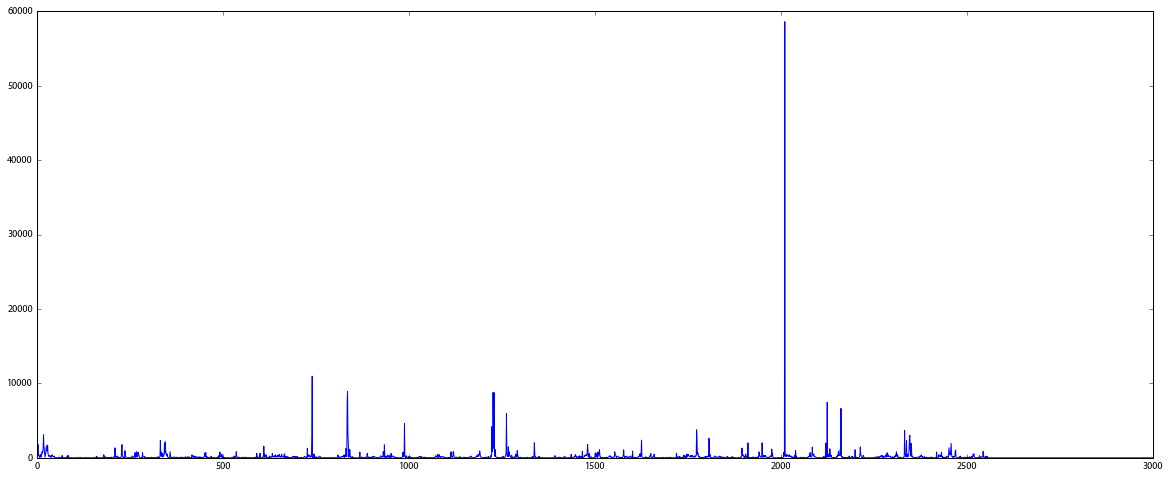

In [90]:
s = pd.Series(data[0]["counts"])
s.plot(figsize=(20,8))